In [1]:
import sys
sys.path.insert(1, '/home/patryk_patrykwrona/repos') # inserting a library's directory

from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

from river import optim
from river import linear_model
from river import forest
from river import tree
from river import ensemble
from river import preprocessing
from river import metrics
from river import dummy
from river import utils
from river import drift
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from Fleuve.master import stream_miner_master
from Fleuve.master import evaluator_master
from Fleuve.master import predictor_master
from Fleuve.master import drift_detector_master

# initialize credit card input
from Fleuve.initialize_credit_card import InitializeCC
from Fleuve.initialize_agrawal import InitializeA
from Fleuve.initialize_hyperplane import InitializeH
from Fleuve.initialize_credit_card_delayed import InitializeCCD

In [3]:
init = InitializeH()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf

23/06/22 22:28:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Stream Miner - Case 5

In [4]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_109272.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_109272.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_109272.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_109272.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_109272.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_109272.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_109272.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_109272.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000), 
                        utils.TimeRolling(metrics.Accuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.BalancedAccuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.F1(), period=dt.timedelta(seconds = 20)), 
                       utils.TimeRolling(metrics.CohenKappa(), period=dt.timedelta(seconds = 20))]}


In [5]:
data_cols = [field.name for field in input_schema.fields][:-1]

# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)

In [6]:
data_cols

['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [6]:
output_schema = sm.output_schema
output_schema

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('TR_Accuracy', FloatType(), False), StructField('TR_BalancedAccuracy', FloatType(), False), StructField('TR_F1', FloatType(), False), StructField('TR_CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('TR_Accuracy_2

In [7]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/case5", "/user/hdfs/evaluation/sm/case5/chk")

23/06/22 22:29:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/06/22 22:29:37 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/06/22 22:30:23 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 45513 milliseconds
23/06/22 22:31:58 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 95583 milliseconds
23/06/22 22:35:27 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 208731 milliseconds
23/06/22 22:41:55 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 387751 milliseconds
23/06/22 22:44:13 WARN ProcessingTimeExecutor: Current batch is fa

KeyboardInterrupt: 

In [8]:
output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/case5")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training
print(pdf[pdf["hostname"] == "cluster-9e14-w-1"].shape)

(200000, 44)
555.61
(72500, 44)


### worker 1

In [9]:
pdf = pdf[pdf["hostname"] == "cluster-9e14-w-0"]
print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["n"] <= 150000]

(127500, 44)
555.61


In [12]:
pdf = pdf[pdf["hash"] == "5legen4uu9nezyla"]

In [11]:
np.unique(pdf.hash, return_counts=True)

(array(['5legen4uu9nezyla', '8n9gdtor59twazbm'], dtype=object),
 array([95000, 32500]))

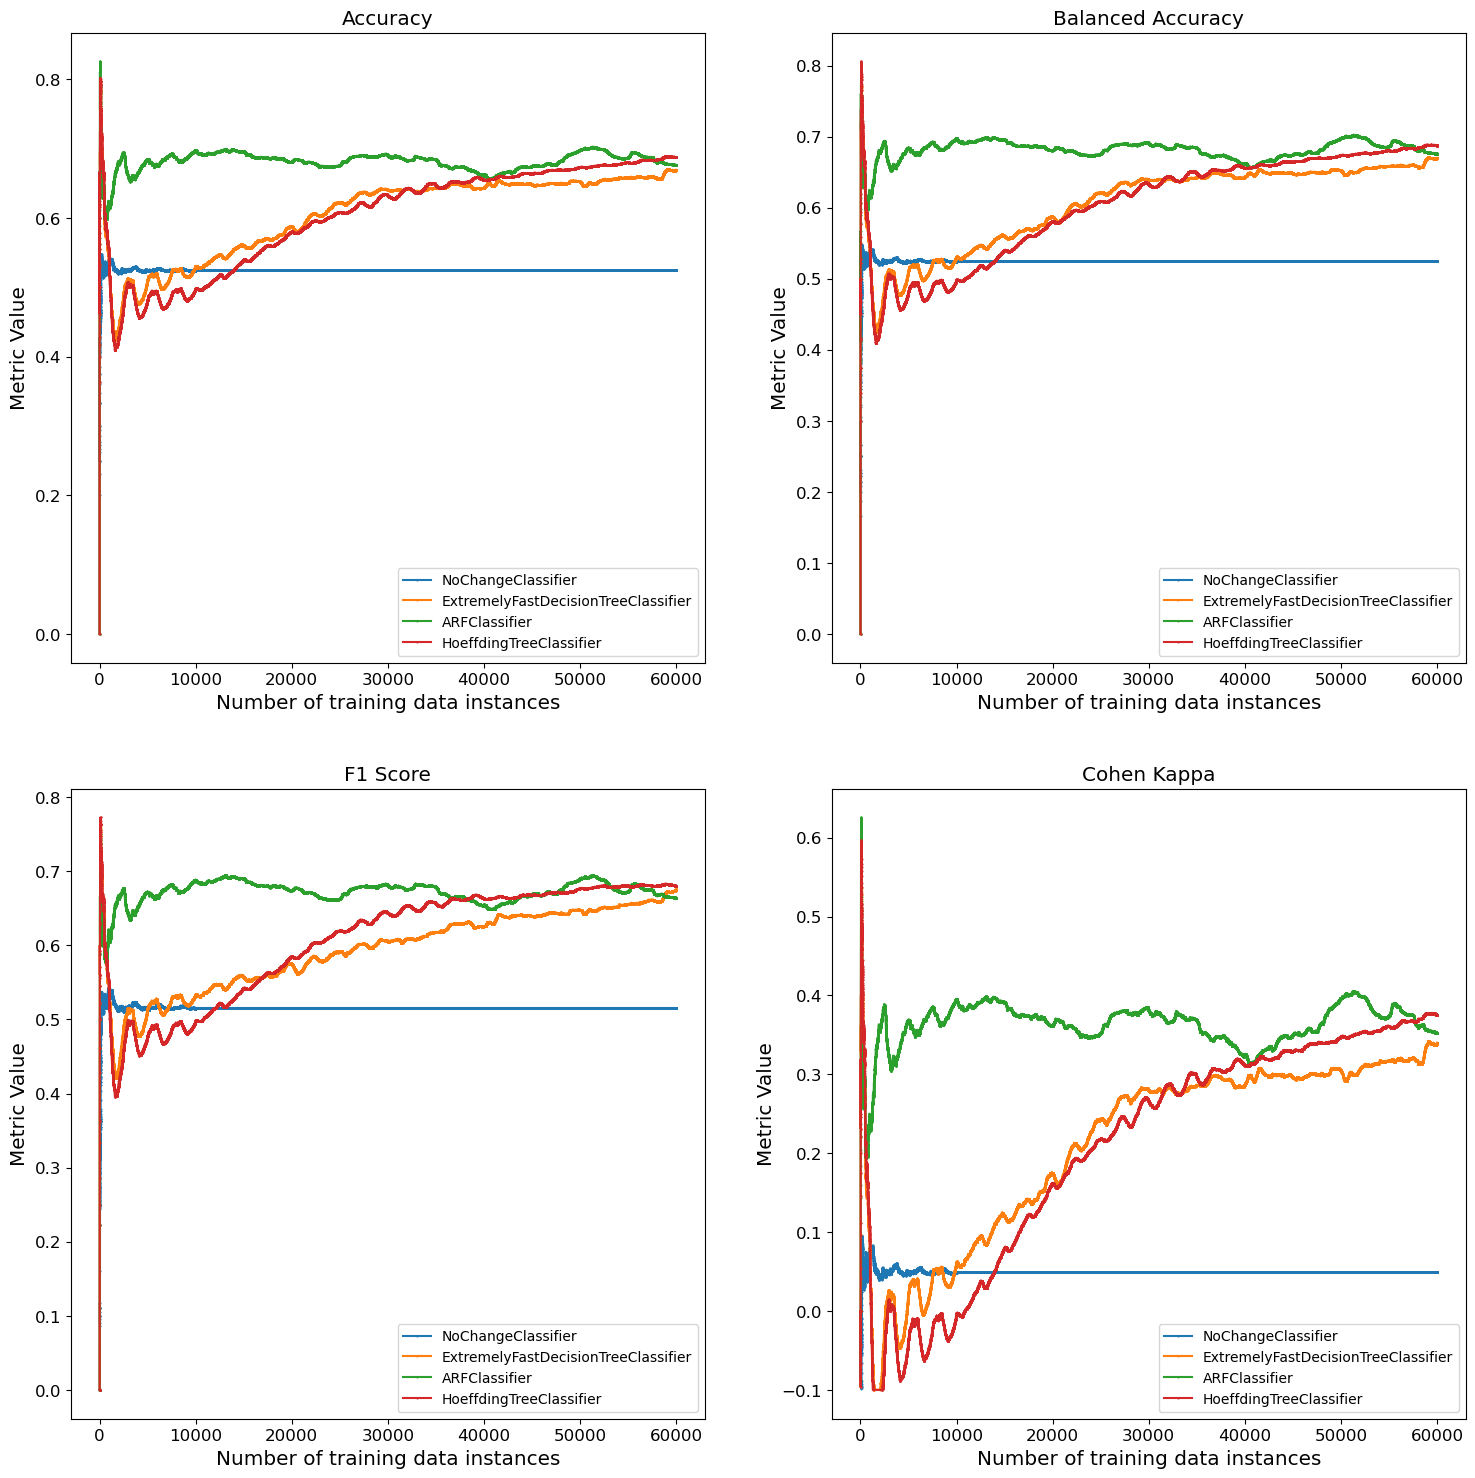

In [26]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 2 --- 

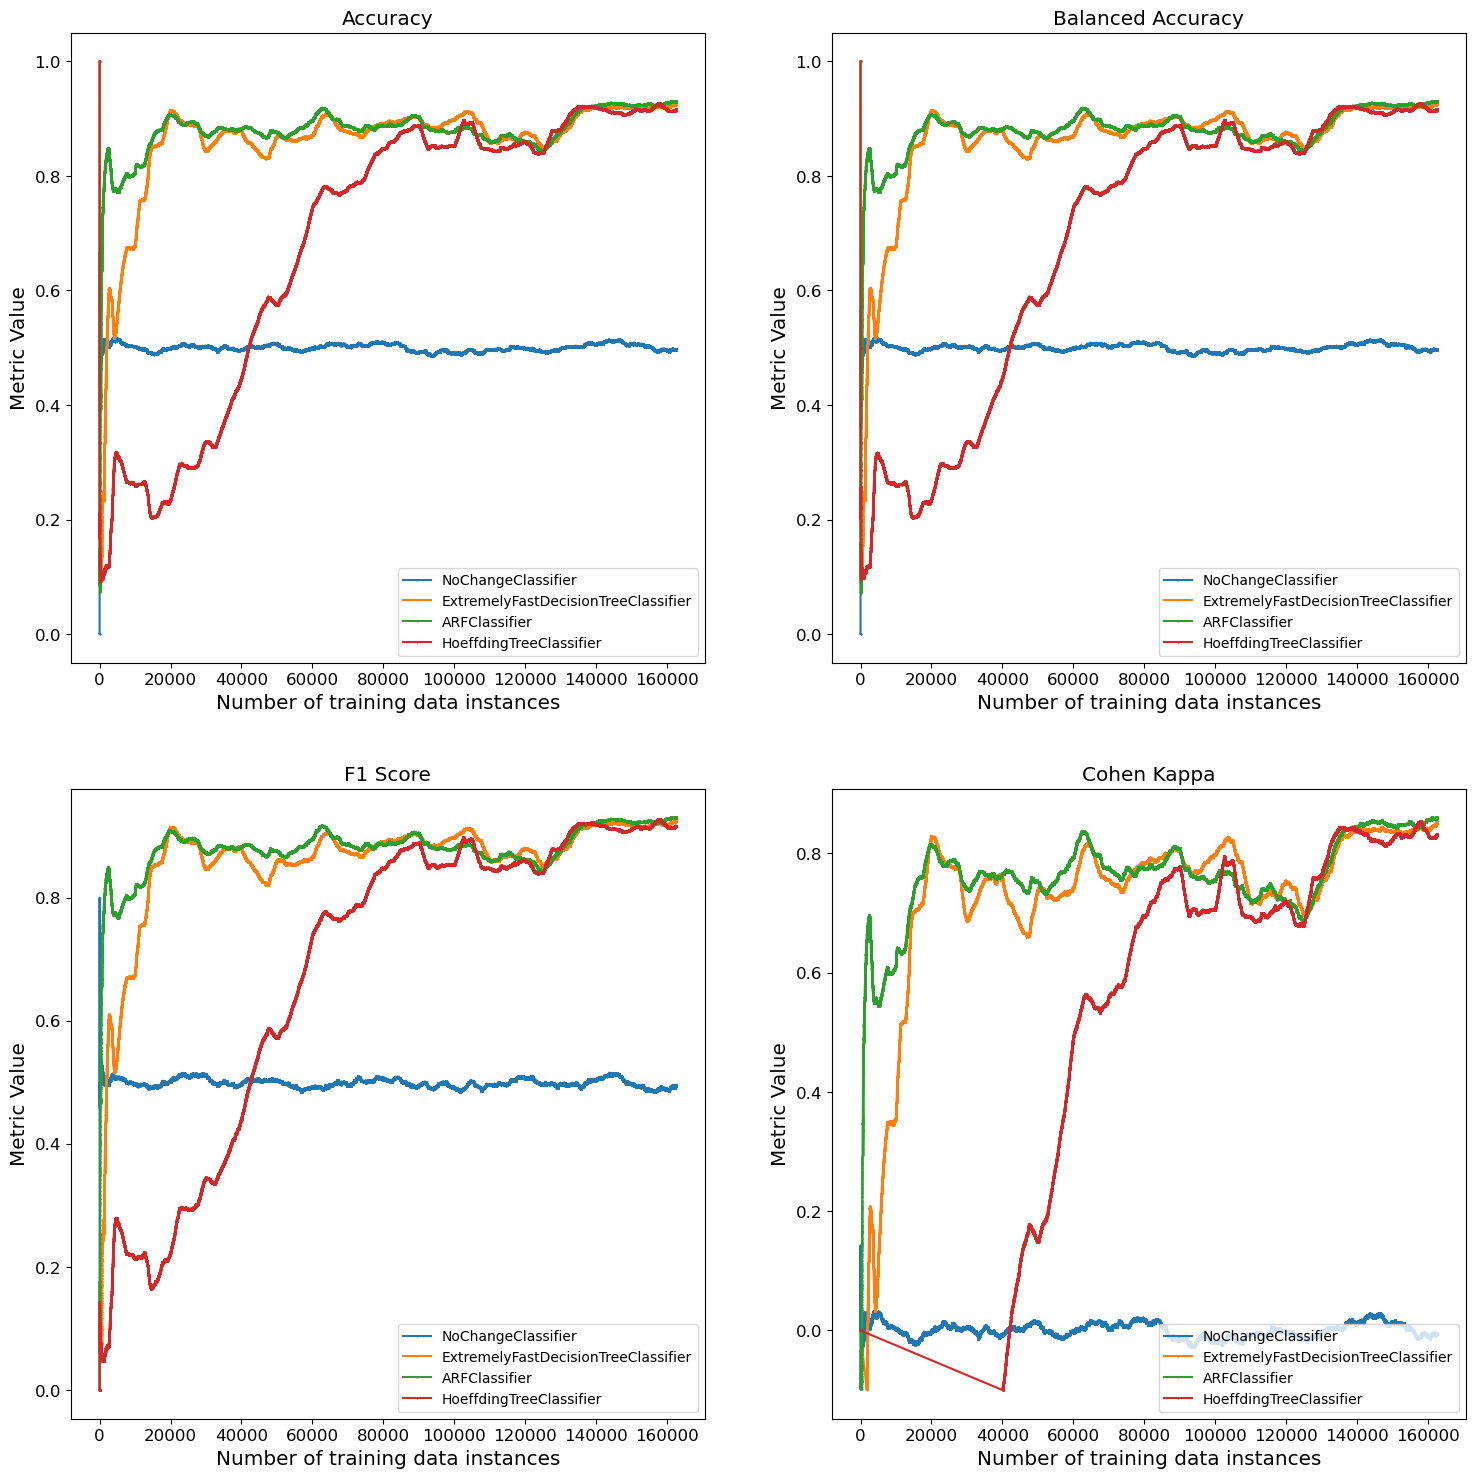

In [14]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# 3

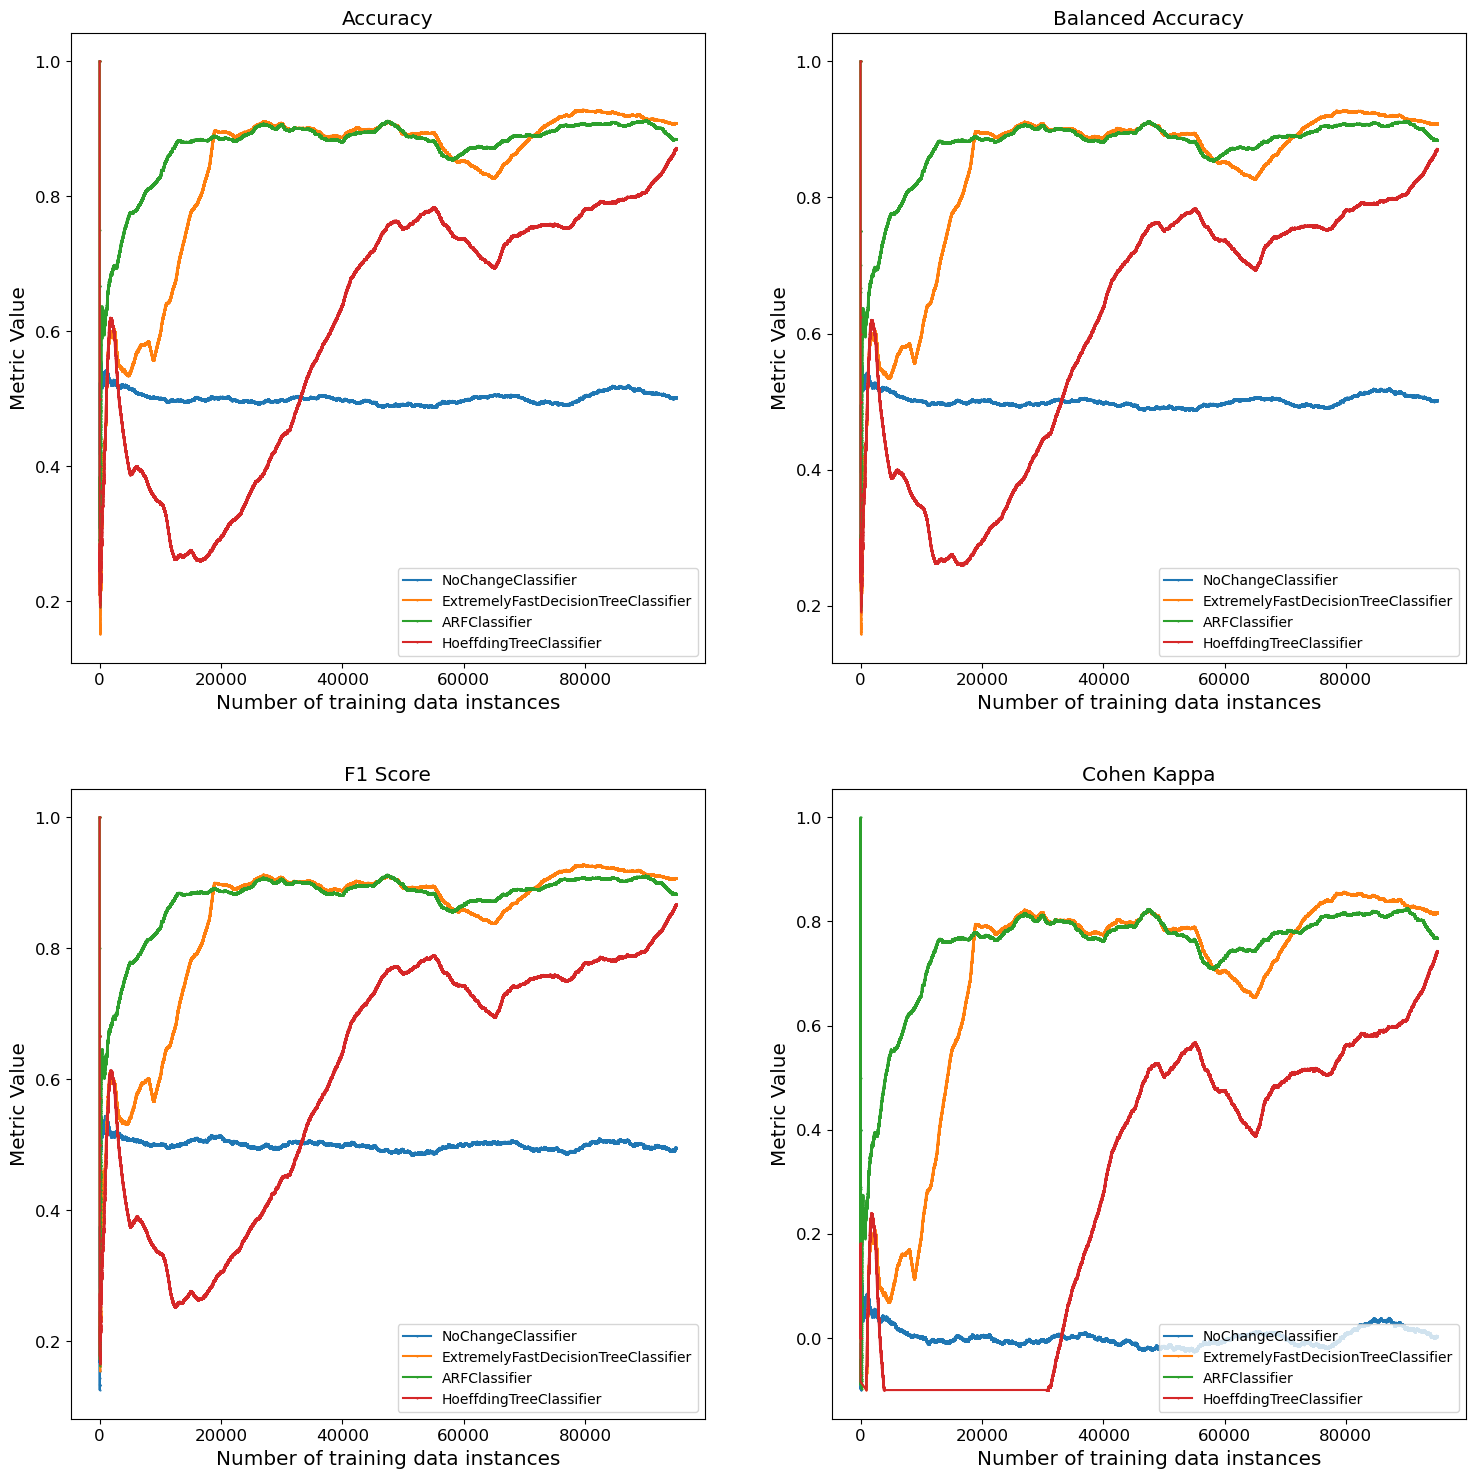

In [13]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

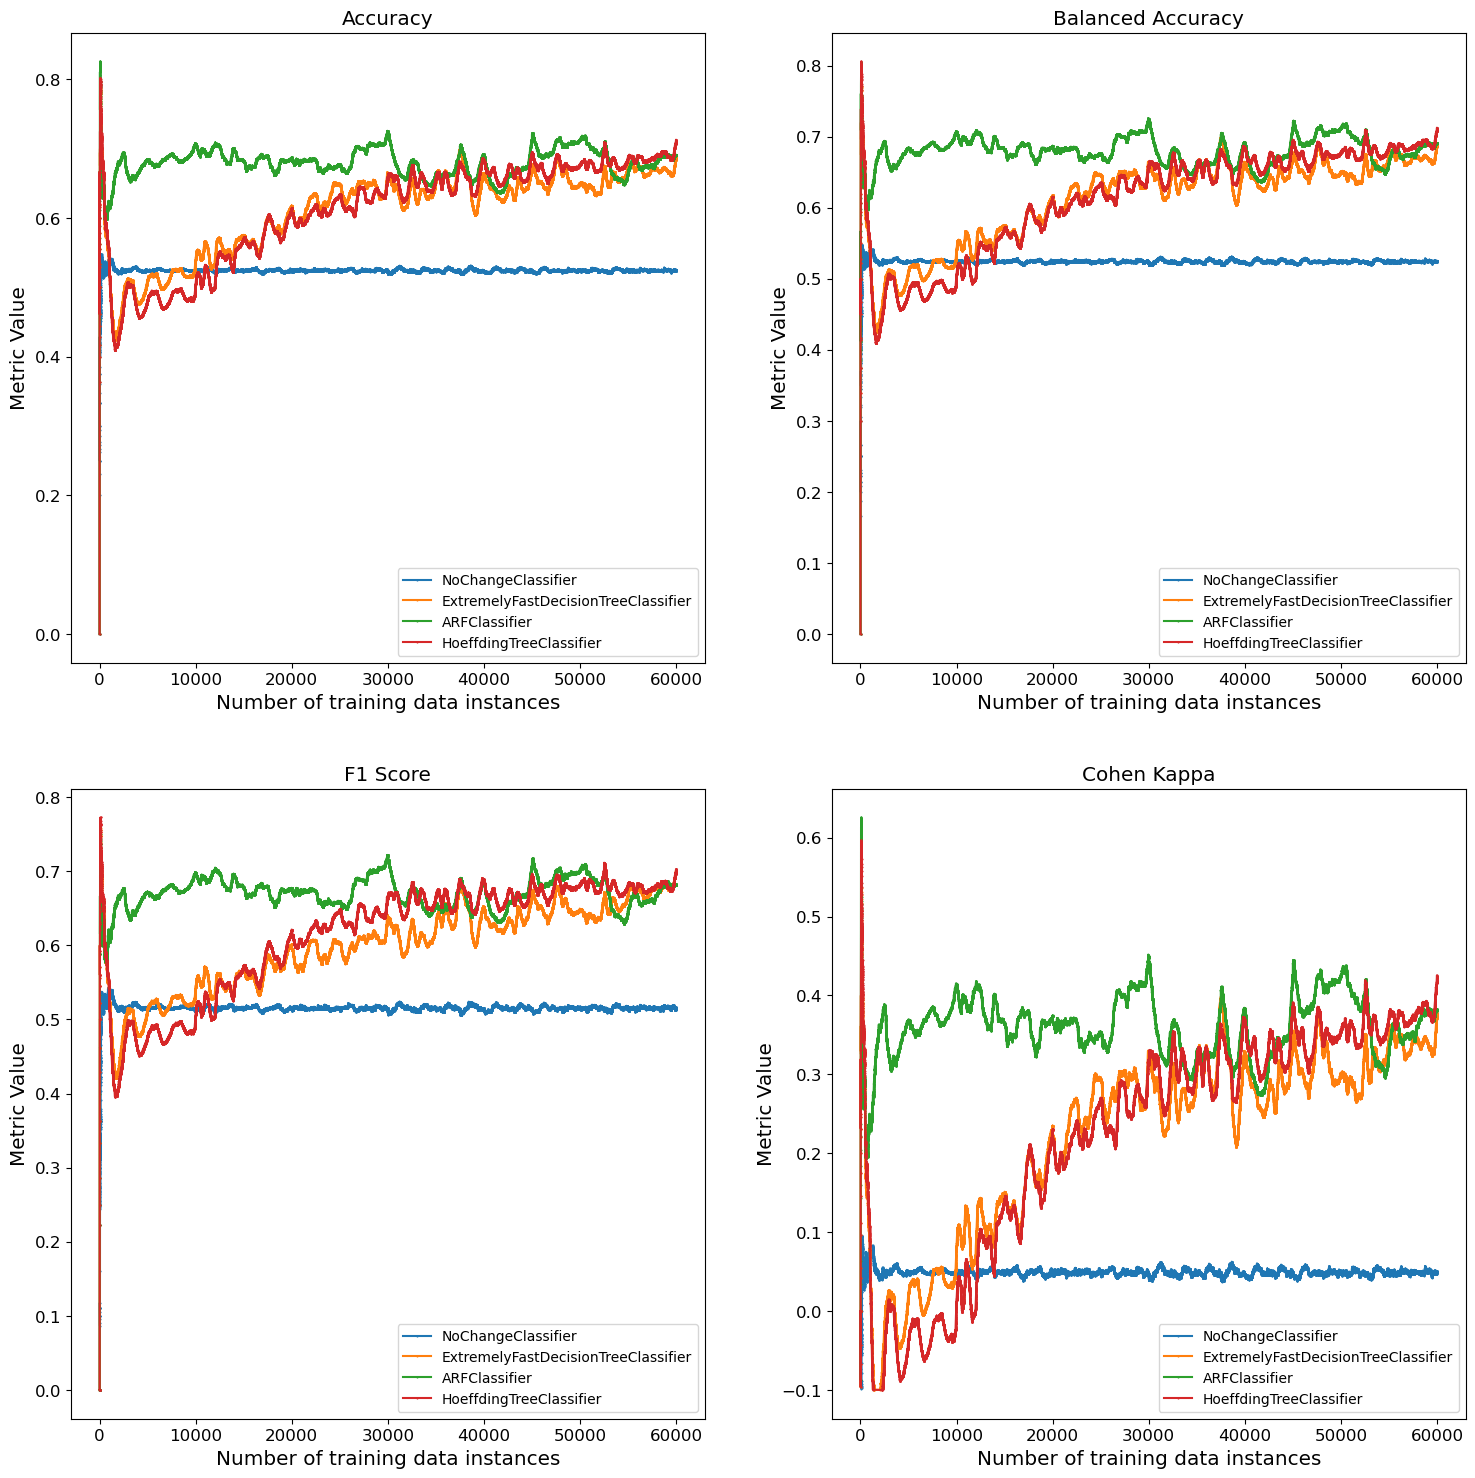

In [25]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 2 ---

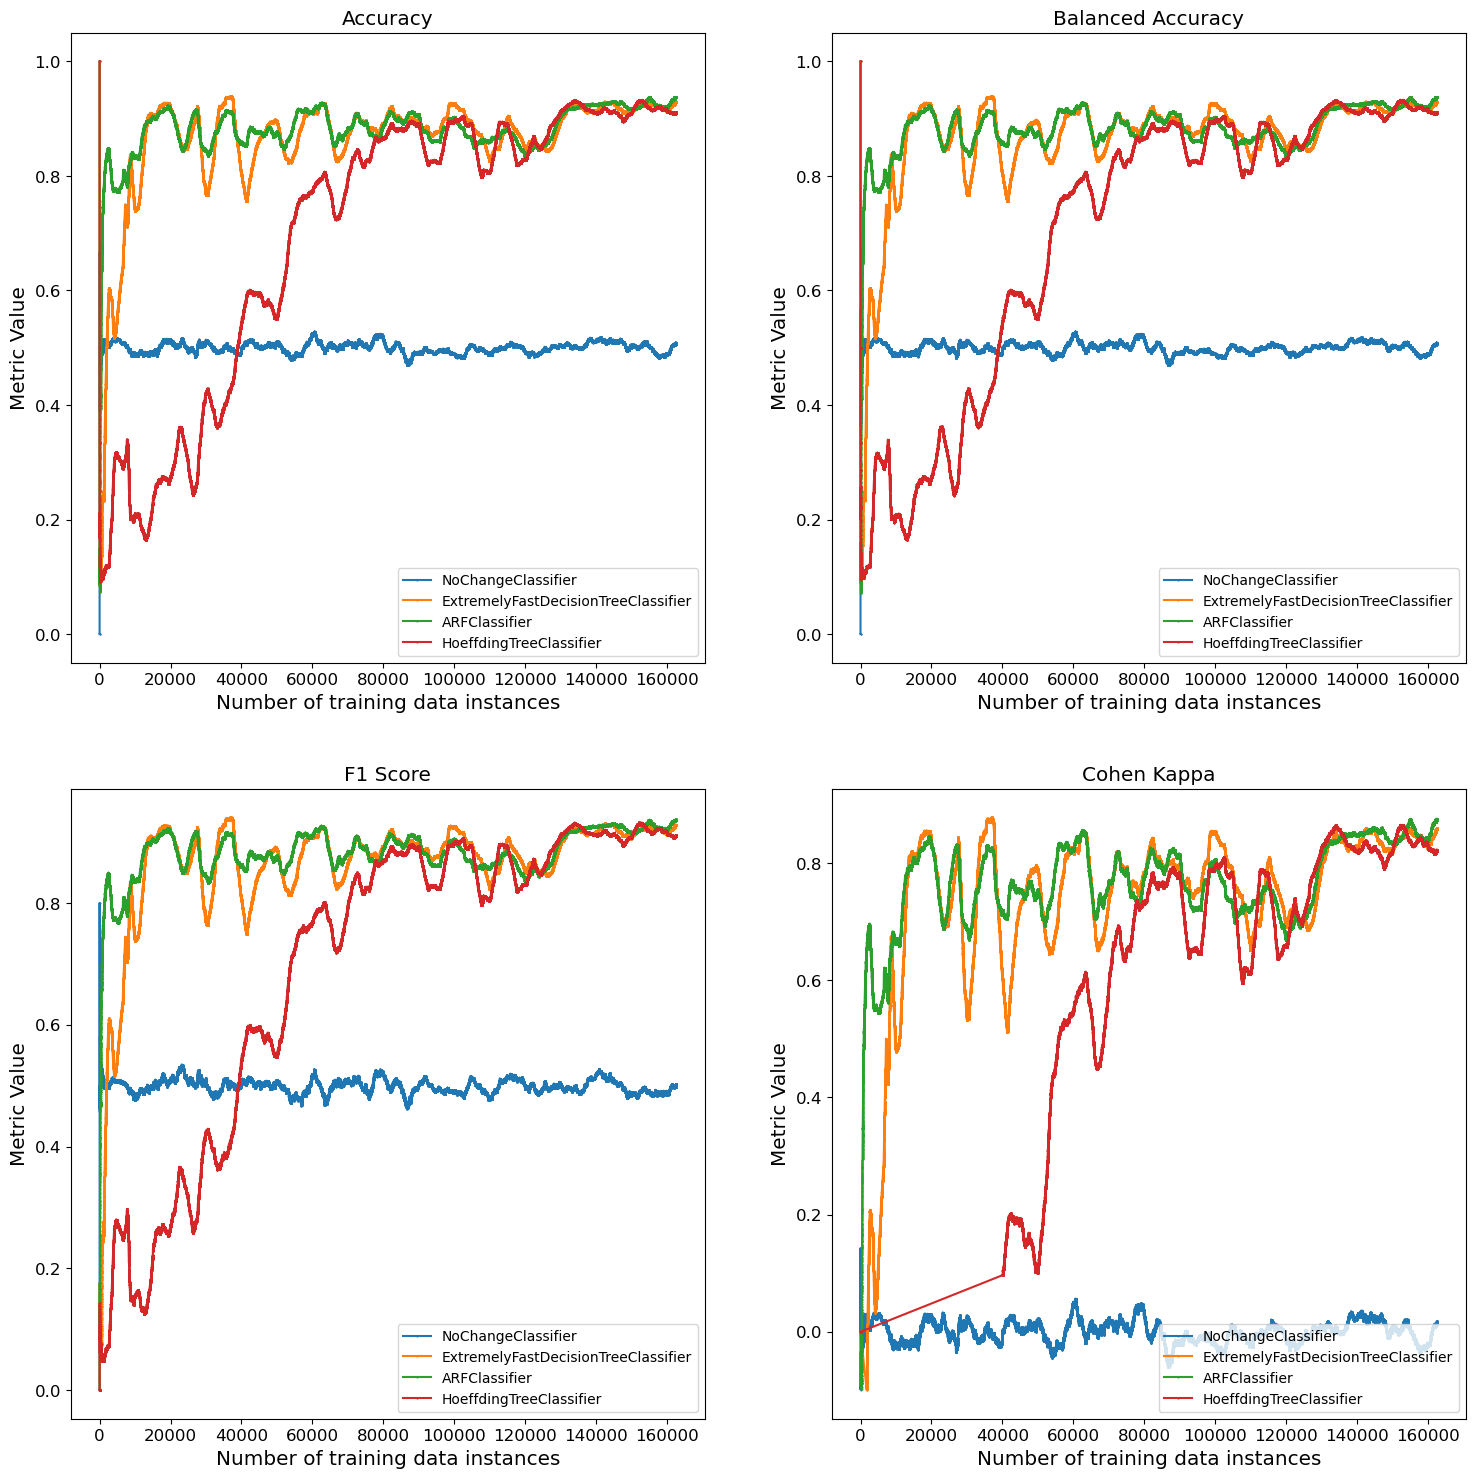

In [15]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# 3

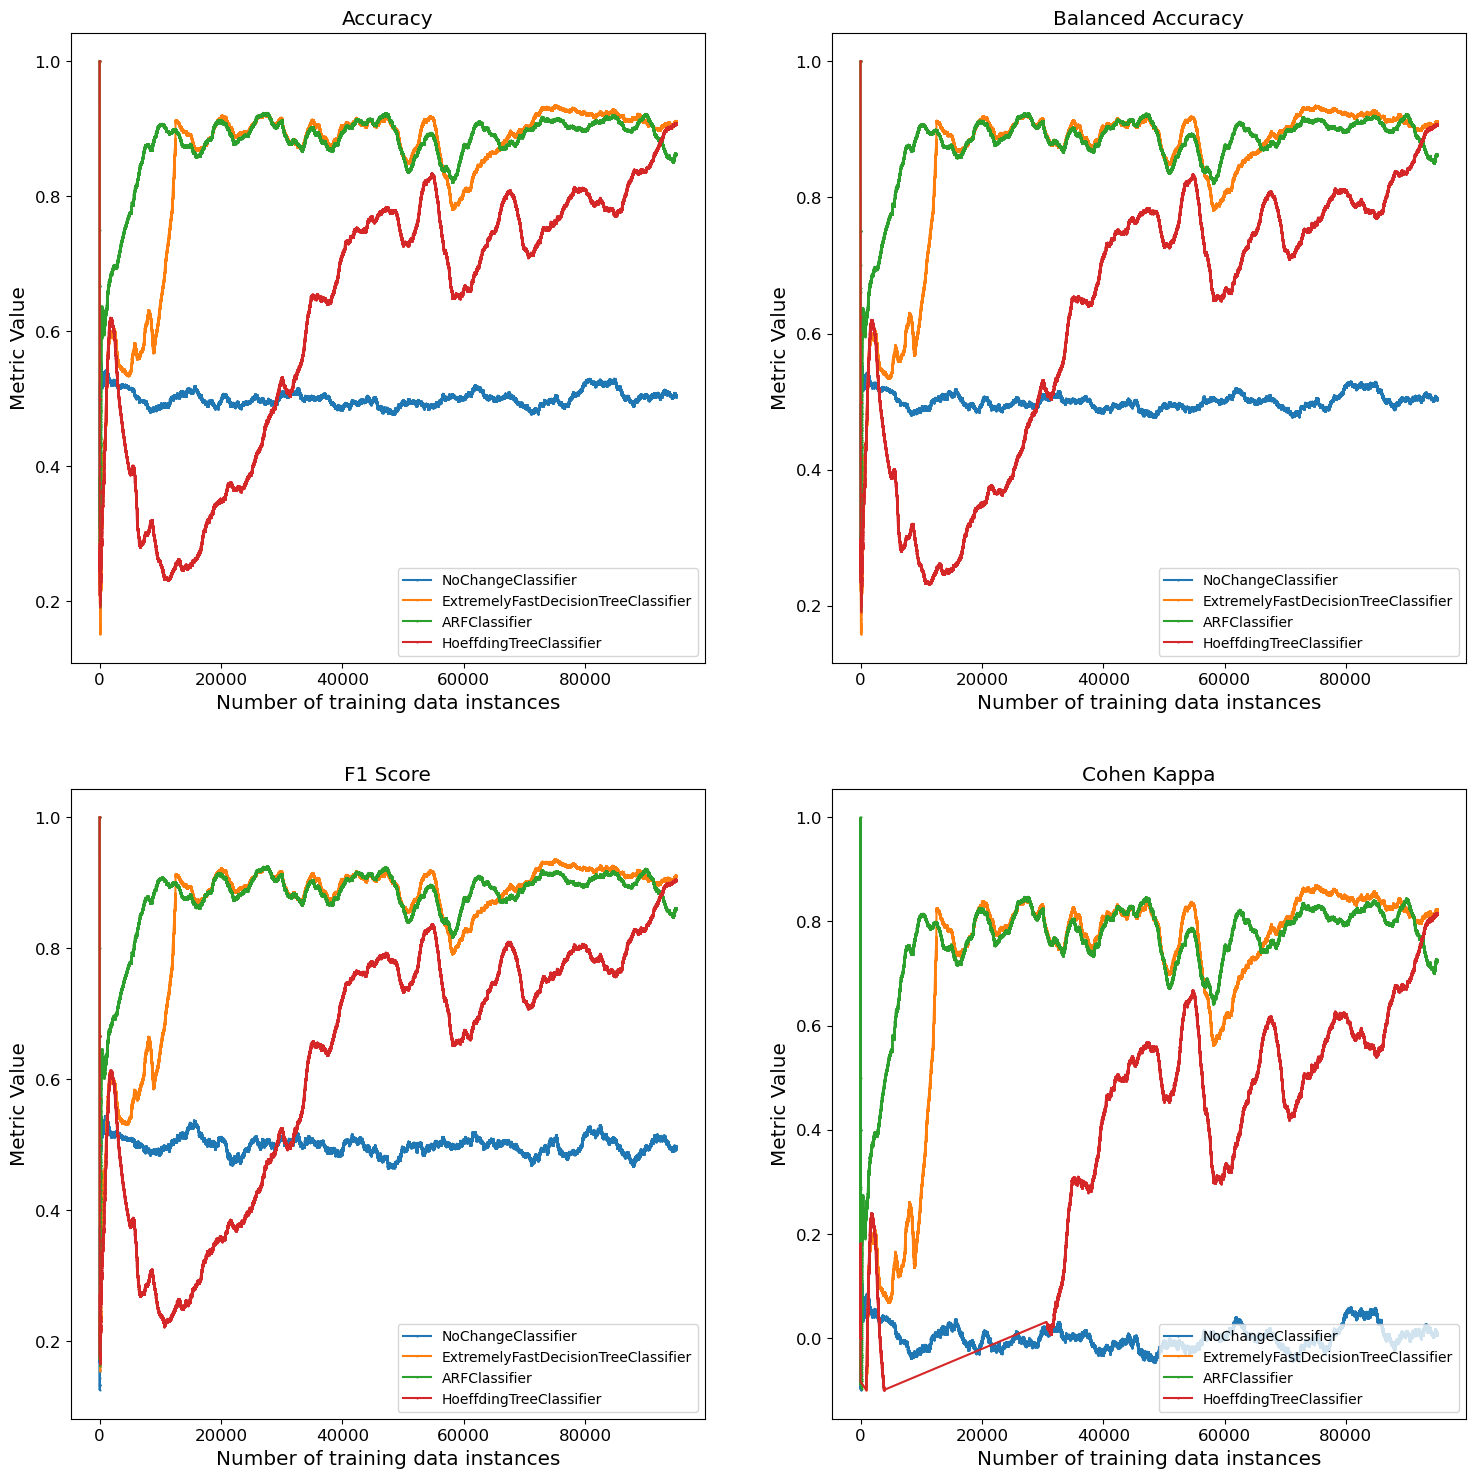

In [14]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Stream Miner - Case 6

In [21]:
init = InitializeA()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf
# spark.stop()

23/06/22 19:16:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/06/22 19:16:21 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/evaluator.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/22 19:16:21 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/shared/evaluator_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/22 19:16:21 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/worker/drift_detector.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/22 19:16:21 WARN SparkContext: The path /home/patryk_patrykwrona/repos/Fleuve/shared/drift_detector_handler.py has been added already. Overwriting of added paths is not supported in the current version.
23/06/22 19:16:21 WARN SparkContext: The path /home/patryk_patrykwrona

In [22]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-1_177460.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_177460.pkl',
                                       'ARFClassifier_cluster-9e14-w-1_177460.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-1_177460.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-1_177460.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_177460.pkl',
                                       'ARFClassifier_cluster-9e14-w-1_177460.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-1_177460.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000)]}

In [23]:
sdf.printSchema()

root
 |-- s: double (nullable = true)
 |-- c: double (nullable = true)
 |-- age: double (nullable = true)
 |-- e: double (nullable = true)
 |-- car: double (nullable = true)
 |-- z: double (nullable = true)
 |-- hv: double (nullable = true)
 |-- hy: double (nullable = true)
 |-- l: double (nullable = true)
 |-- Class: double (nullable = true)



In [24]:
data_cols = [field.name for field in input_schema.fields][:-1]

# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)

In [33]:
# sdf = None

In [25]:
output_schema = sm.output_schema
# output_schema

In [26]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/case6", "/user/hdfs/evaluation/sm/case6/chk")

23/06/22 19:19:05 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/06/22 19:19:56 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 50195 milliseconds
23/06/22 19:21:46 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 109939 milliseconds
23/06/22 19:25:49 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 243665 milliseconds
23/06/22 19:34:25 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 515977 milliseconds
23/06/22 19:35:55 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 90111 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File

KeyboardInterrupt: 

In [30]:
output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/case6")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training


(200000, 28)
972.1178


In [28]:
pdf = pdf[pdf["hostname"] == "cluster-9e14-w-1"]
print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["n"] <= 100000]

(200000, 28)
972.1178


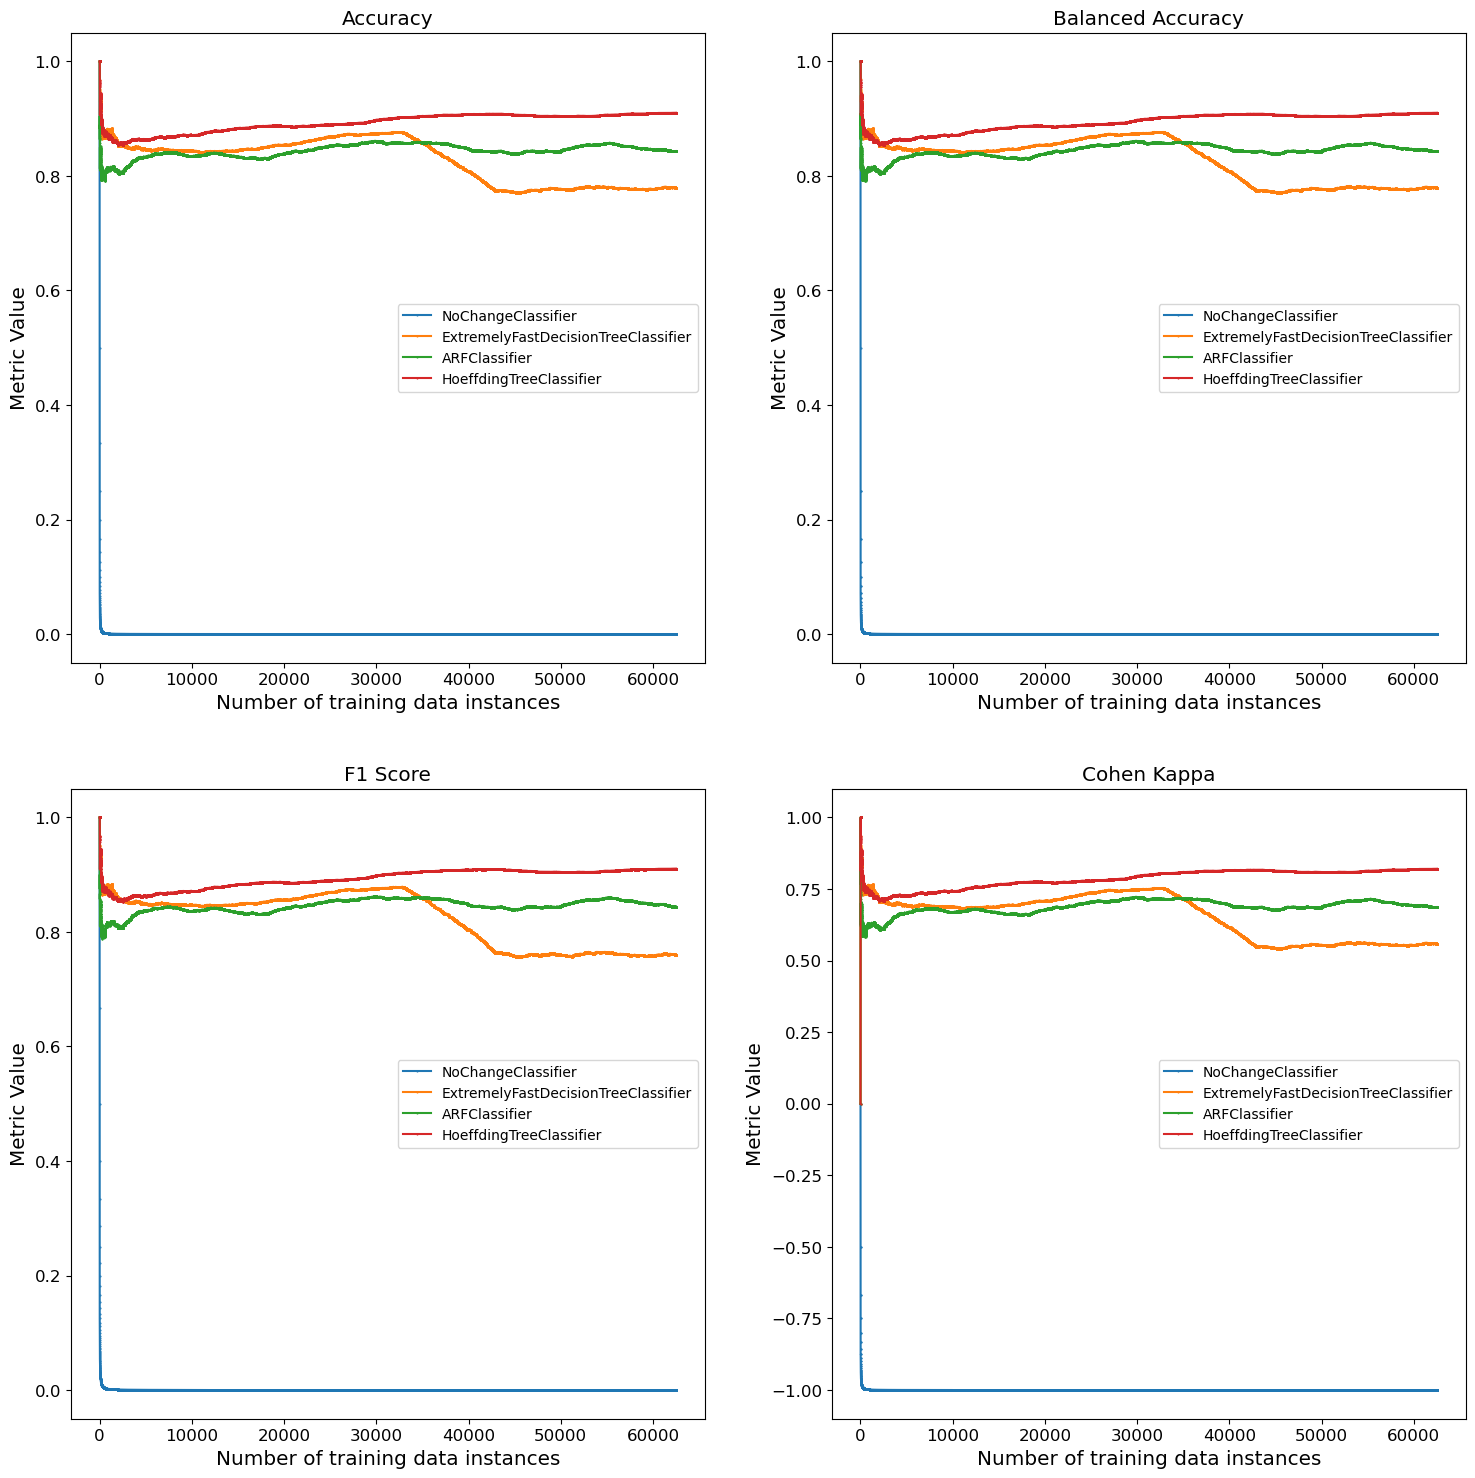

In [46]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 2 ---

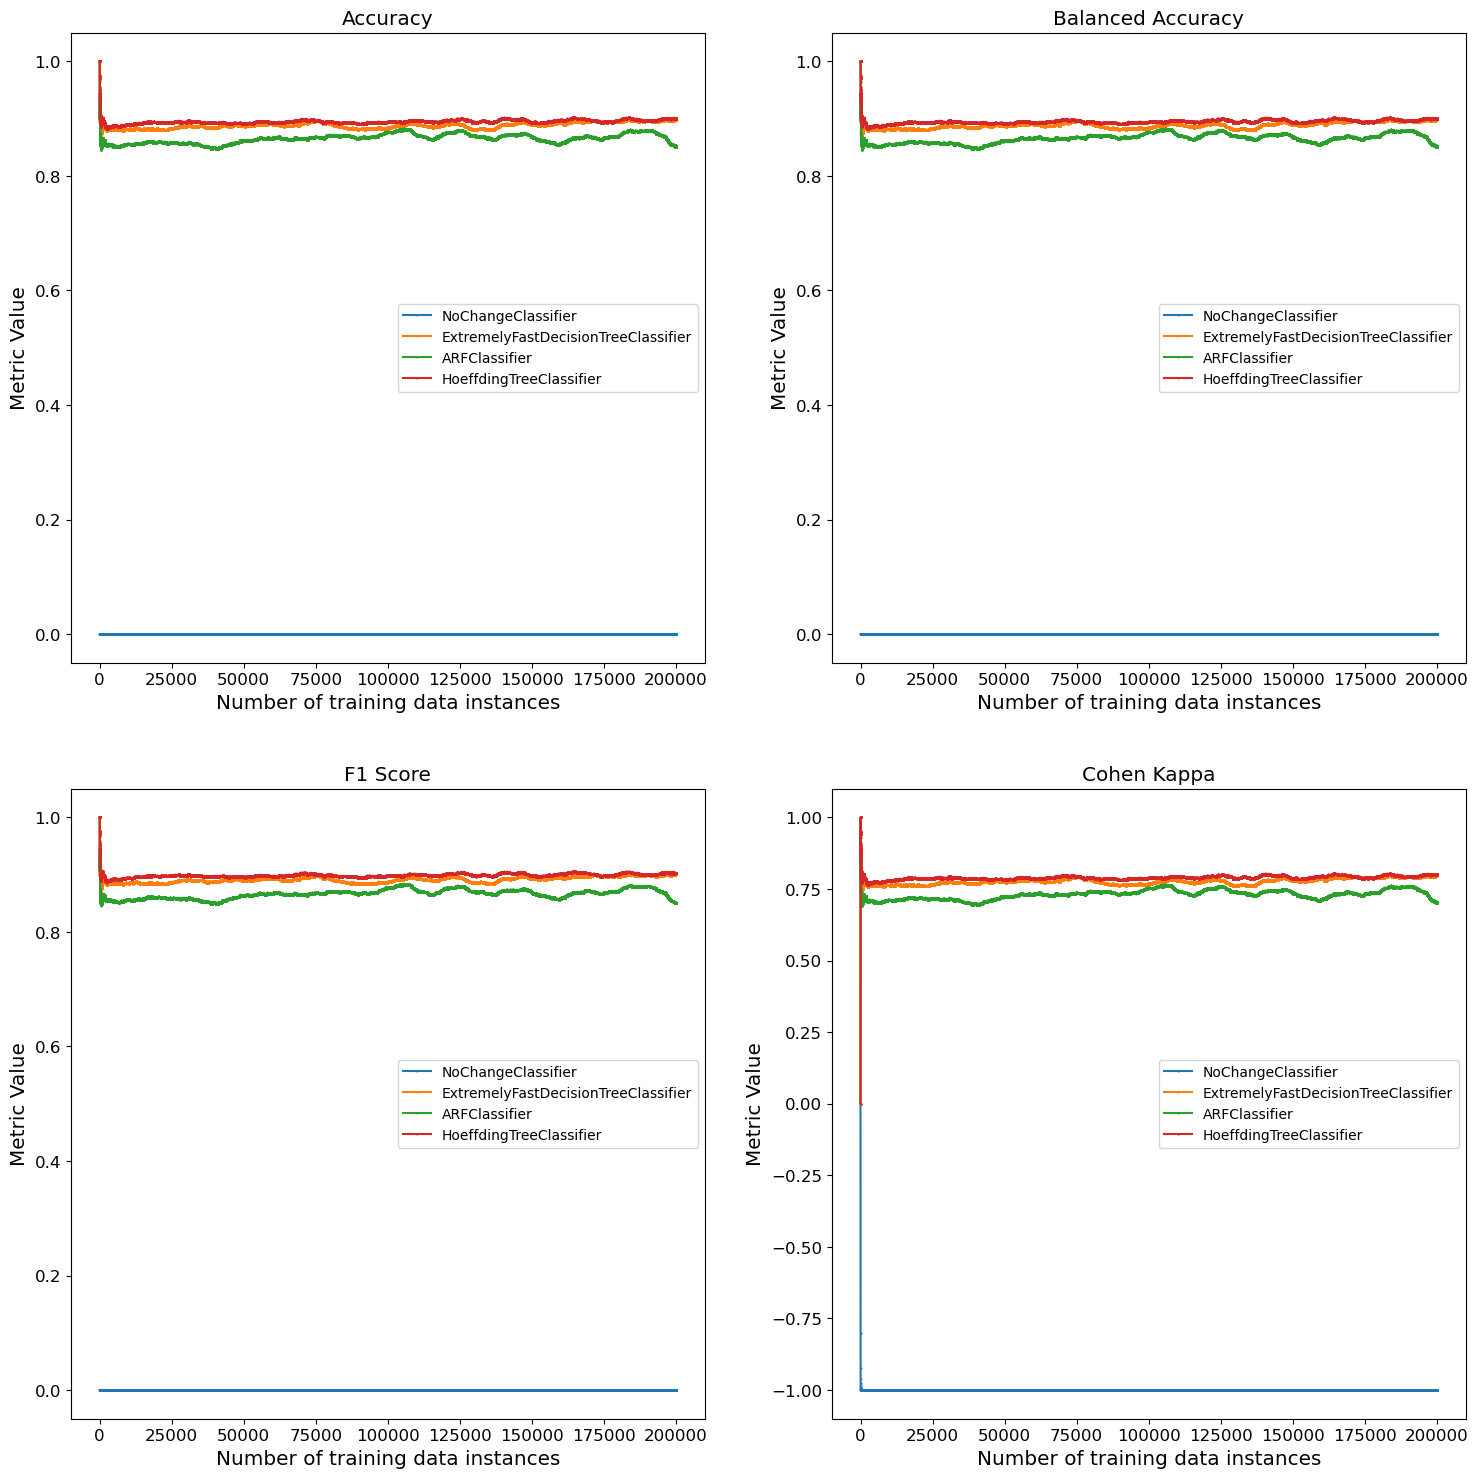

In [31]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

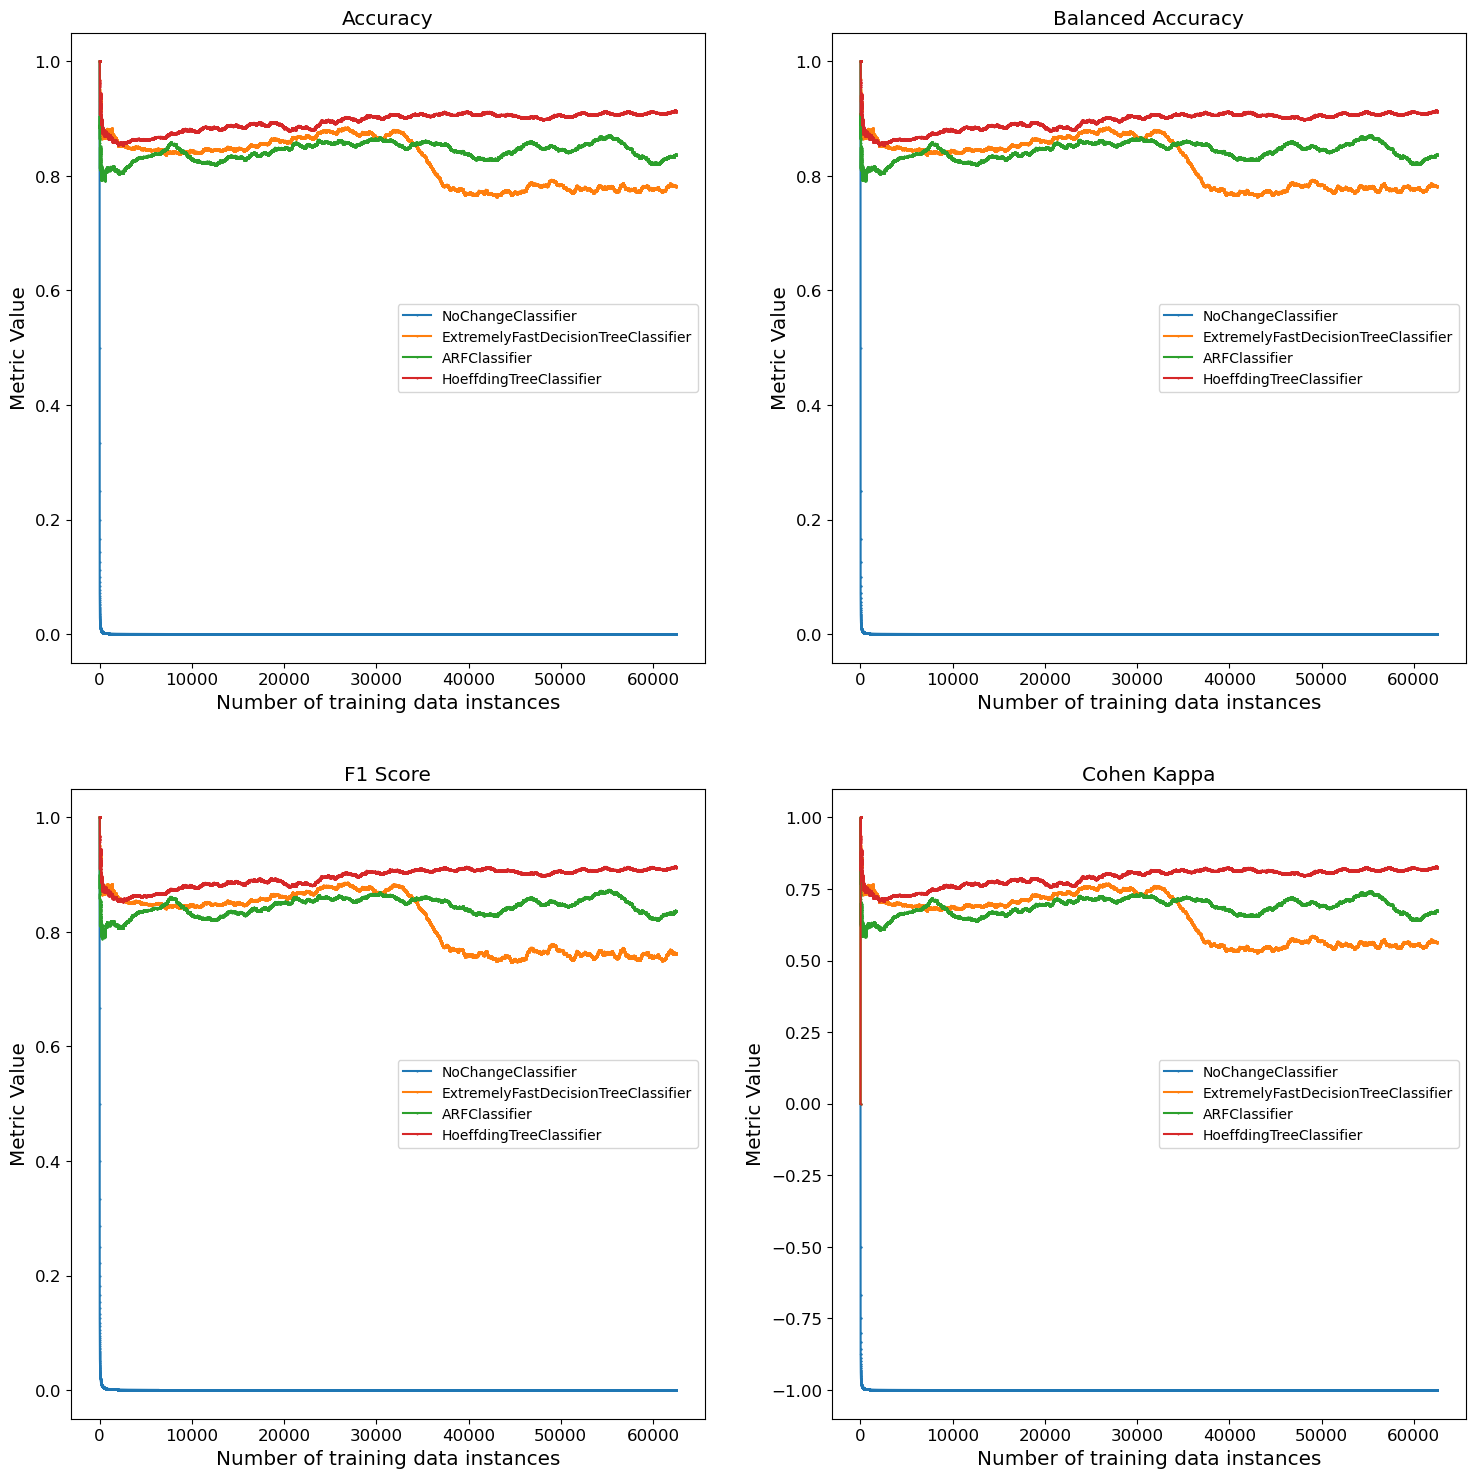

In [45]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'center right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### no TimeRolling in attempt 2

# Evaluator - Case 1

In [2]:
init = InitializeCC()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf
# spark.stop()

23/06/23 13:25:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_271321.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_271321.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_271321.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_271321.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000), 
                        utils.TimeRolling(metrics.Accuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.BalancedAccuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.F1(), period=dt.timedelta(seconds = 20)), 
                       utils.TimeRolling(metrics.CohenKappa(), period=dt.timedelta(seconds = 20))]}

In [5]:
# data_cols = [field.name for field in input_schema.fields][1:-2]

data_cols = ['V' + str(i) for i in range(1,29)]
data_cols.append('Amount') 

sm = evaluator_master.EvaluatorMaster(data_cols, task )

In [7]:
data_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [6]:
output_schema = sm.output_schema
output_schema

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('TR_Accuracy', FloatType(), False), StructField('TR_BalancedAccuracy', FloatType(), False), StructField('TR_F1', FloatType(), False), StructField('TR_CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('TR_Accuracy_2

In [6]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/em/case1", "/user/hdfs/evaluation/em/case1/chk")

23/06/15 06:32:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/06/15 06:32:12 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/06/15 06:43:01 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 648010 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
Keyboard

KeyboardInterrupt: 

In [7]:
output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/em/case1")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training
pdf = pdf[pdf["hostname"] == "cluster-9e14-w-0"]
pdf = pdf[pdf["hash"] == "tb7l1mejg49slivk"]
print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

pdf = pdf[pdf["n"] <= 100000]

23/06/23 13:25:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(284807, 44)
601.30164
(138313, 44)
573.7681


In [18]:
pdf.tail(10)

training_time      n          hostname              hash  \
196488     181.138474  49995  cluster-9e14-w-0  tb7l1mejg49slivk   
196489     181.141663  49996  cluster-9e14-w-0  tb7l1mejg49slivk   
49995      187.006760  49996  cluster-9e14-w-0  qaku40qvf4xczlsg   
196490     181.143738  49997  cluster-9e14-w-0  tb7l1mejg49slivk   
49996      187.011322  49997  cluster-9e14-w-0  qaku40qvf4xczlsg   
49997      187.015717  49998  cluster-9e14-w-0  qaku40qvf4xczlsg   
196491     181.146011  49998  cluster-9e14-w-0  tb7l1mejg49slivk   
196492     181.147476  49999  cluster-9e14-w-0  tb7l1mejg49slivk   
49998      187.019104  49999  cluster-9e14-w-0  qaku40qvf4xczlsg   
49999      187.021652  50000  cluster-9e14-w-0  qaku40qvf4xczlsg   

                model_name  prediction  R_Accuracy  R_BalancedAccuracy  R_F1  \
196488  NoChangeClassifier         0.0      0.9986                 0.5   0.0   
196489  NoChangeClassifier         0.0      0.9986                 0.5   0.0   
49995   NoChangeClassifier         0.0      0.9956                 0.5   0.0   
196490  NoChangeClassifier         0.0      0.9986                 0.5   0.0   
49996   NoChangeClassifier         0.0      0.9956                 0.5   0.0   
49997   NoChangeClassifier         0.0      0.9956                 0.5   0.0   
196491  NoChangeClassifier         0.0      0.9986                 0.5   0.0   
196492  NoChangeClassifier         0.0      0.9986                 0.5   0.0   
49998   NoChangeClassifier         0.0      0.9956                 0.5   0.0   
49999   NoChangeClassifier         0.0      0.9956                 0.5   0.0   

        R_CohenKappa  ...             model_name_4  prediction_4  \
196488           0.0  ...  HoeffdingTreeClassifier           0.0   
196489           0.0  ...  HoeffdingTreeClassifier           0.0   
49995            0.0  ...  HoeffdingTreeClassifier           0.0   
196490           0.0  ...  HoeffdingTreeClassifier           0.0   
49996            0.0  ...  HoeffdingTreeClassifier           0.0   
49997            0.0  ...  HoeffdingTreeClassifier           0.0   
196491           0.0  ...  HoeffdingTreeClassifier           0.0   
196492           0.0  ...  HoeffdingTreeClassifier           0.0   
49998            0.0  ...  HoeffdingTreeClassifier           0.0   
49999            0.0  ...  HoeffdingTreeClassifier           0.0   

        R_Accuracy_4  R_BalancedAccuracy_4    R_F1_4  R_CohenKappa_4  \
196488        0.9994              0.821379  0.750000        0.749708   
196489        0.9994              0.821379  0.750000        0.749708   
49995         0.9994              0.965758  0.931818        0.931517   
196490        0.9994              0.821379  0.750000        0.749708   
49996         0.9994              0.965758  0.931818        0.931517   
49997         0.9994              0.965758  0.931818        0.931517   
196491        0.9994              0.821379  0.750000        0.749708   
196492        0.9994              0.821379  0.750000        0.749708   
49998         0.9994              0.965758  0.931818        0.931517   
49999         0.9994              0.965758  0.931818        0.931517   

        TR_Accuracy_4  TR_BalancedAccuracy_4   TR_F1_4  TR_CohenKappa_4  
196488       0.999542               0.800000  0.750000         0.749785  
196489       0.999542               0.800000  0.750000         0.749785  
49995        0.999775               0.916667  0.909091         0.908979  
196490       0.999542               0.800000  0.750000         0.749785  
49996        0.999775               0.916667  0.909091         0.908979  
49997        0.999775               0.916667  0.909091         0.908979  
196491       0.999542               0.800000  0.750000         0.749785  
196492       0.999542               0.800000  0.750000         0.749785  
49998        0.999775               0.916667  0.909091         0.908979  
49999        0.999775               0.916667  0.909091         0.908979  

[10 rows x 44 columns

In [16]:
pdf = pdf.iloc[0:99999, :]

In [17]:
np.unique(pdf.n, return_counts = True)

(array([    1,     2,     3, ..., 49998, 49999, 50000], dtype=int32),
 array([2, 2, 2, ..., 2, 2, 1]))

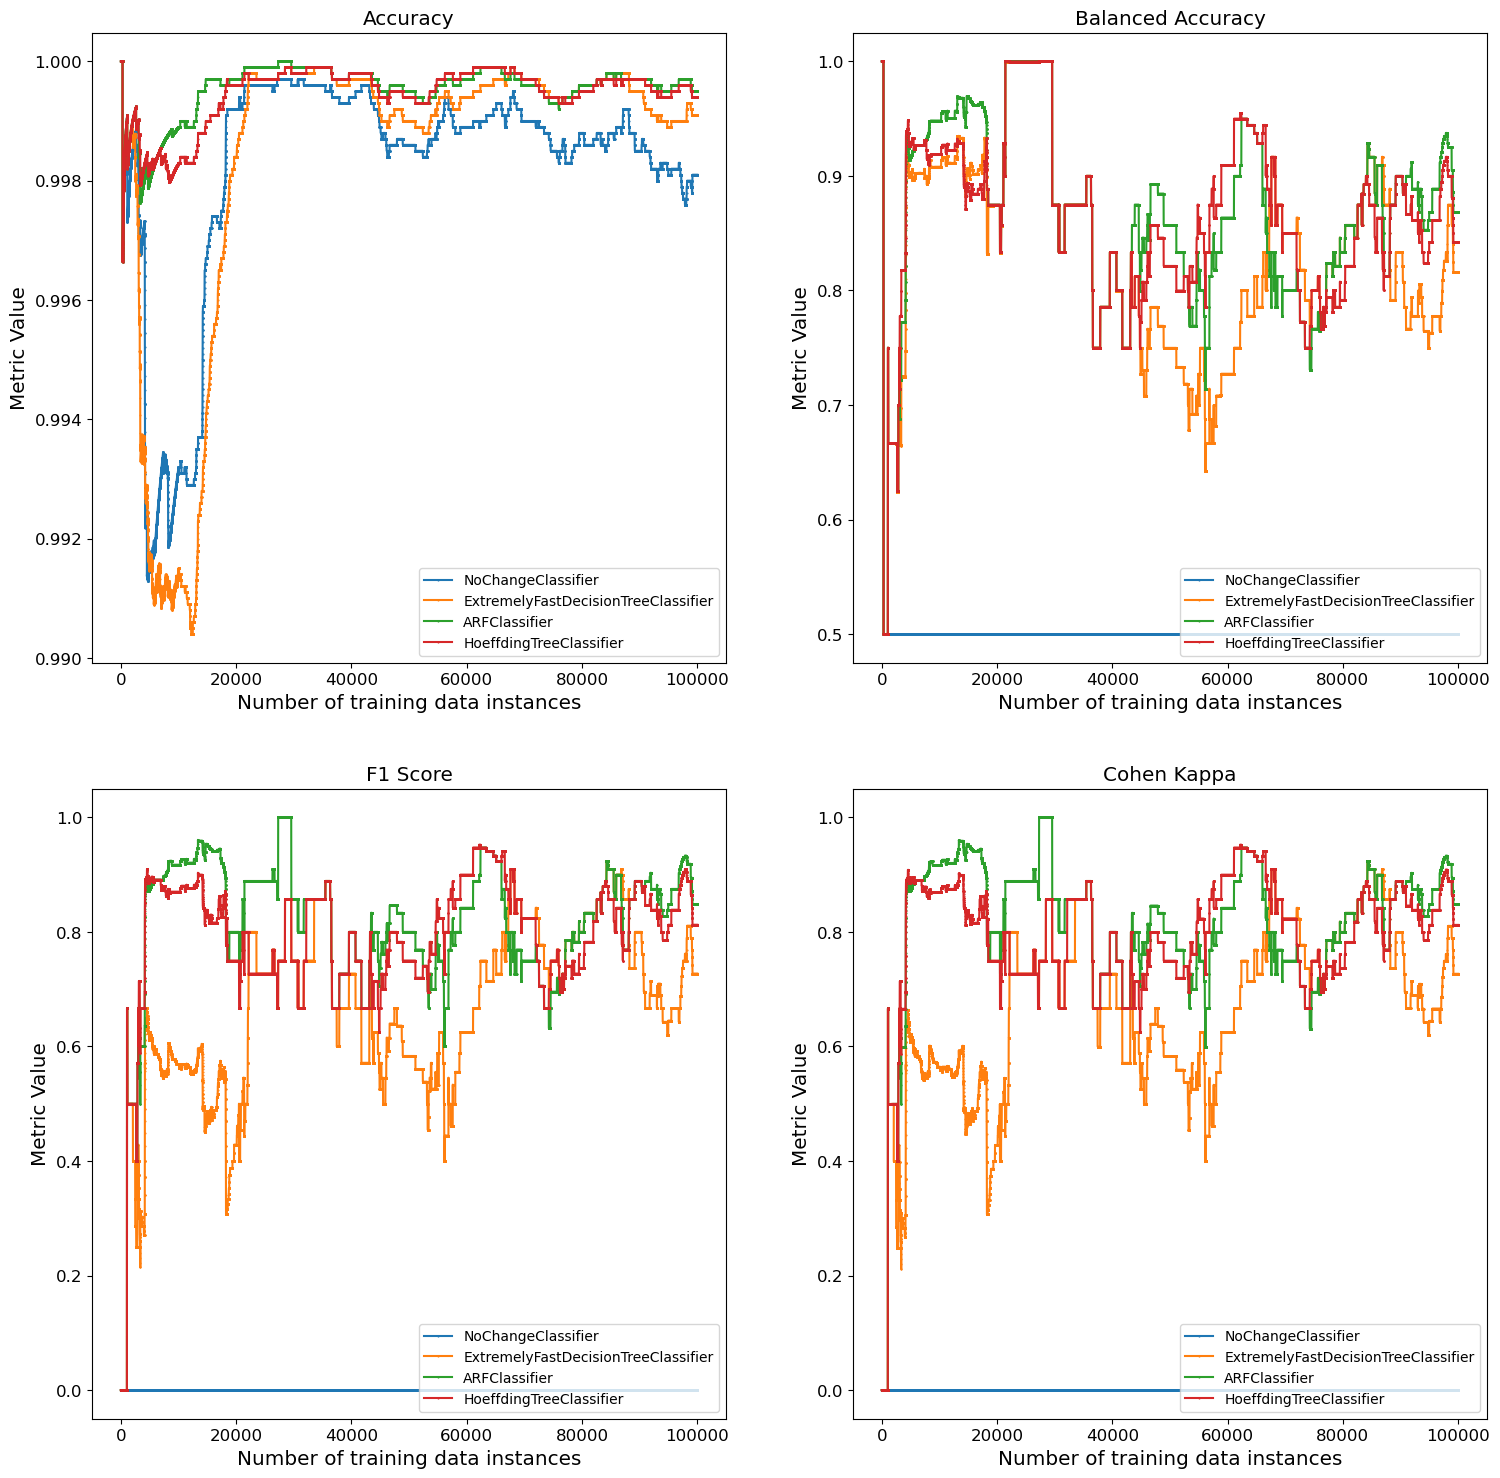

In [25]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [15]:
aux = pdf.dropna()

In [16]:
aux.shape

(100000, 46)

In [17]:
pdf.shape

(107528, 46)

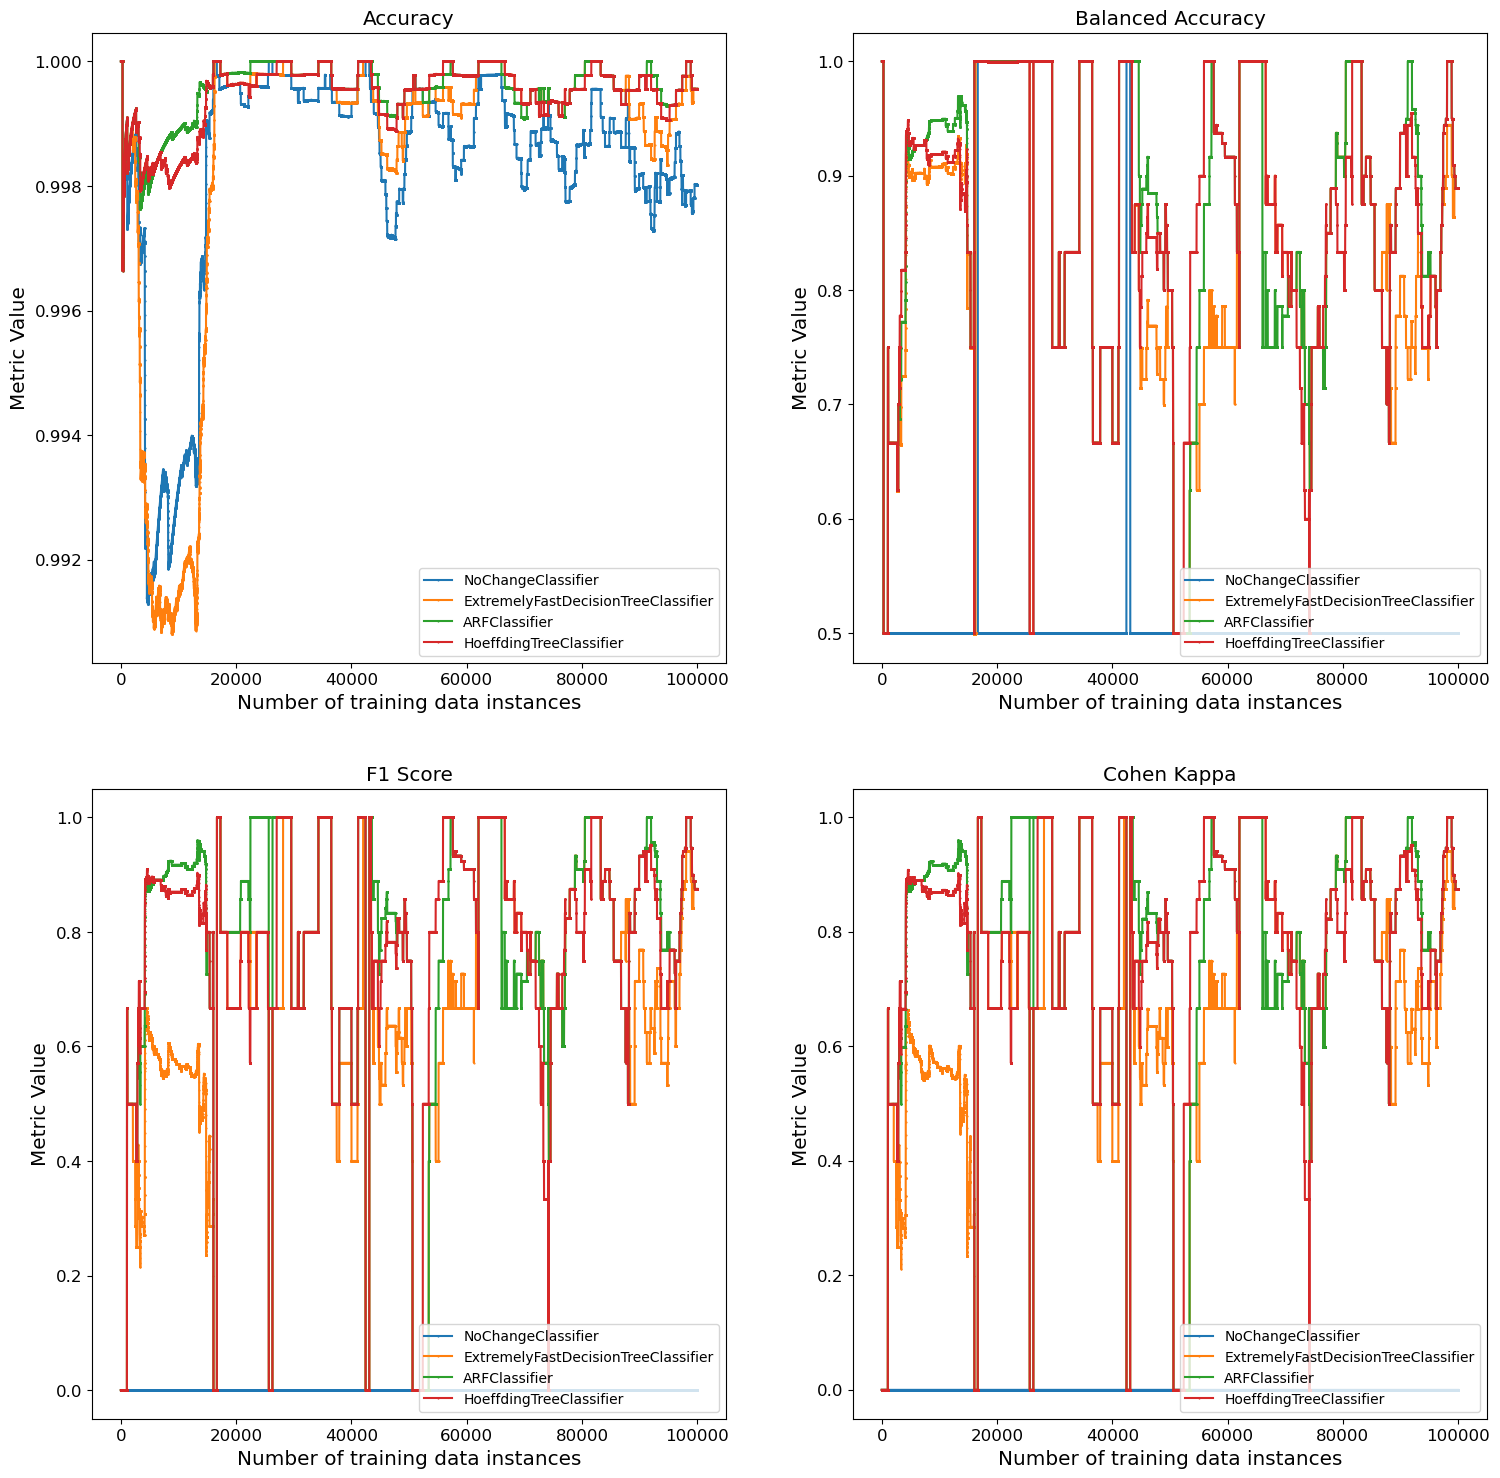

In [26]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Evaluator - case 2

In [2]:
init = InitializeH()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf
# spark.stop()

23/06/22 22:03:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_109272.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_109272.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_109272.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_109272.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-0_109272.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-0_109272.pkl',
                                       'ARFClassifier_cluster-9e14-w-0_109272.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-0_109272.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000), 
                        metrics.Accuracy(), 
                        metrics.BalancedAccuracy(), 
                        metrics.F1(), 
                        metrics.CohenKappa()]}

In [4]:
data_cols = [field.name for field in input_schema.fields][:-1]

# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = evaluator_master.EvaluatorMaster(data_cols, task)

In [5]:
data_cols

['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
output_schema = sm.output_schema
output_schema

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('Accuracy', FloatType(), False), StructField('BalancedAccuracy', FloatType(), False), StructField('F1', FloatType(), False), StructField('CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('Accuracy_2', FloatType(),

In [6]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/em/case2", "/user/hdfs/evaluation/em/case2/chk")

23/06/22 22:04:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/06/22 22:04:22 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/06/22 22:05:02 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 27321 milliseconds
23/06/22 22:05:14 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 11869 milliseconds
23/06/22 22:05:41 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 27291 milliseconds
23/06/22 22:05:47 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 6140 milliseconds
ERROR:root:KeyboardInterrupt while sending command.                  

KeyboardInterrupt: 

In [7]:
output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/em/case2")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training
pdf = pdf[pdf["hostname"] == "cluster-9e14-w-0"]
print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["n"] <= 200000]

(397500, 44)
916.42474
(397500, 44)
916.42474


In [10]:
pdf = pdf[pdf["hash"] == "fkkyimyieglwnhxj"]

In [9]:
np.unique(pdf.hash, return_counts=True)

(array(['8lijnsoivtdcqerf', 'fkkyimyieglwnhxj'], dtype=object),
 array([170000, 227500]))

In [11]:
np.max(pdf["n"])

227500

In [25]:
pdf.head(50)

training_time   n          hostname              hash          model_name  \
0        0.000570   1  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
1        0.001149   2  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
2        0.001614   3  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
3        0.002040   4  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
4        0.002500   5  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
5        0.002875   6  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
6        0.003280   7  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
7        0.003667   8  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
8        0.004034   9  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
9        0.004557  10  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
10       0.004940  11  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
11       0.005572  12  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
12       0.006029  13  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
13       0.006479  14  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
14       0.006902  15  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
15       0.007294  16  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
16       0.007711  17  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
17       0.008122  18  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
18       0.008583  19  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
19       0.008994  20  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
20       0.009398  21  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
21       0.009828  22  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
22       0.010204  23  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
23       0.010573  24  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
24       0.010986  25  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
25       0.011367  26  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
26       0.011774  27  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
27       0.012187  28  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
28       0.012679  29  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
29       0.013116  30  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
30       0.013861  31  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
31       0.014558  32  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
32       0.014967  33  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
33       0.015373  34  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
34       0.015786  35  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
35       0.016177  36  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
36       0.016631  37  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
37       0.017017  38  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
38       0.017481  39  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
39       0.017907  40  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
40       0.018301  41  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
41       0.018726  42  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
42       0.019182  43  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
43       0.019557  44  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
44       0.019966  45  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
45       0.020363  46  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
46       0.020842  47  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
47       0.021216  48  cluster-9e14-w-0  wxs81othdkjeyxnk  NoChangeClassifier   
48       0.021608  49  cluster-9e14

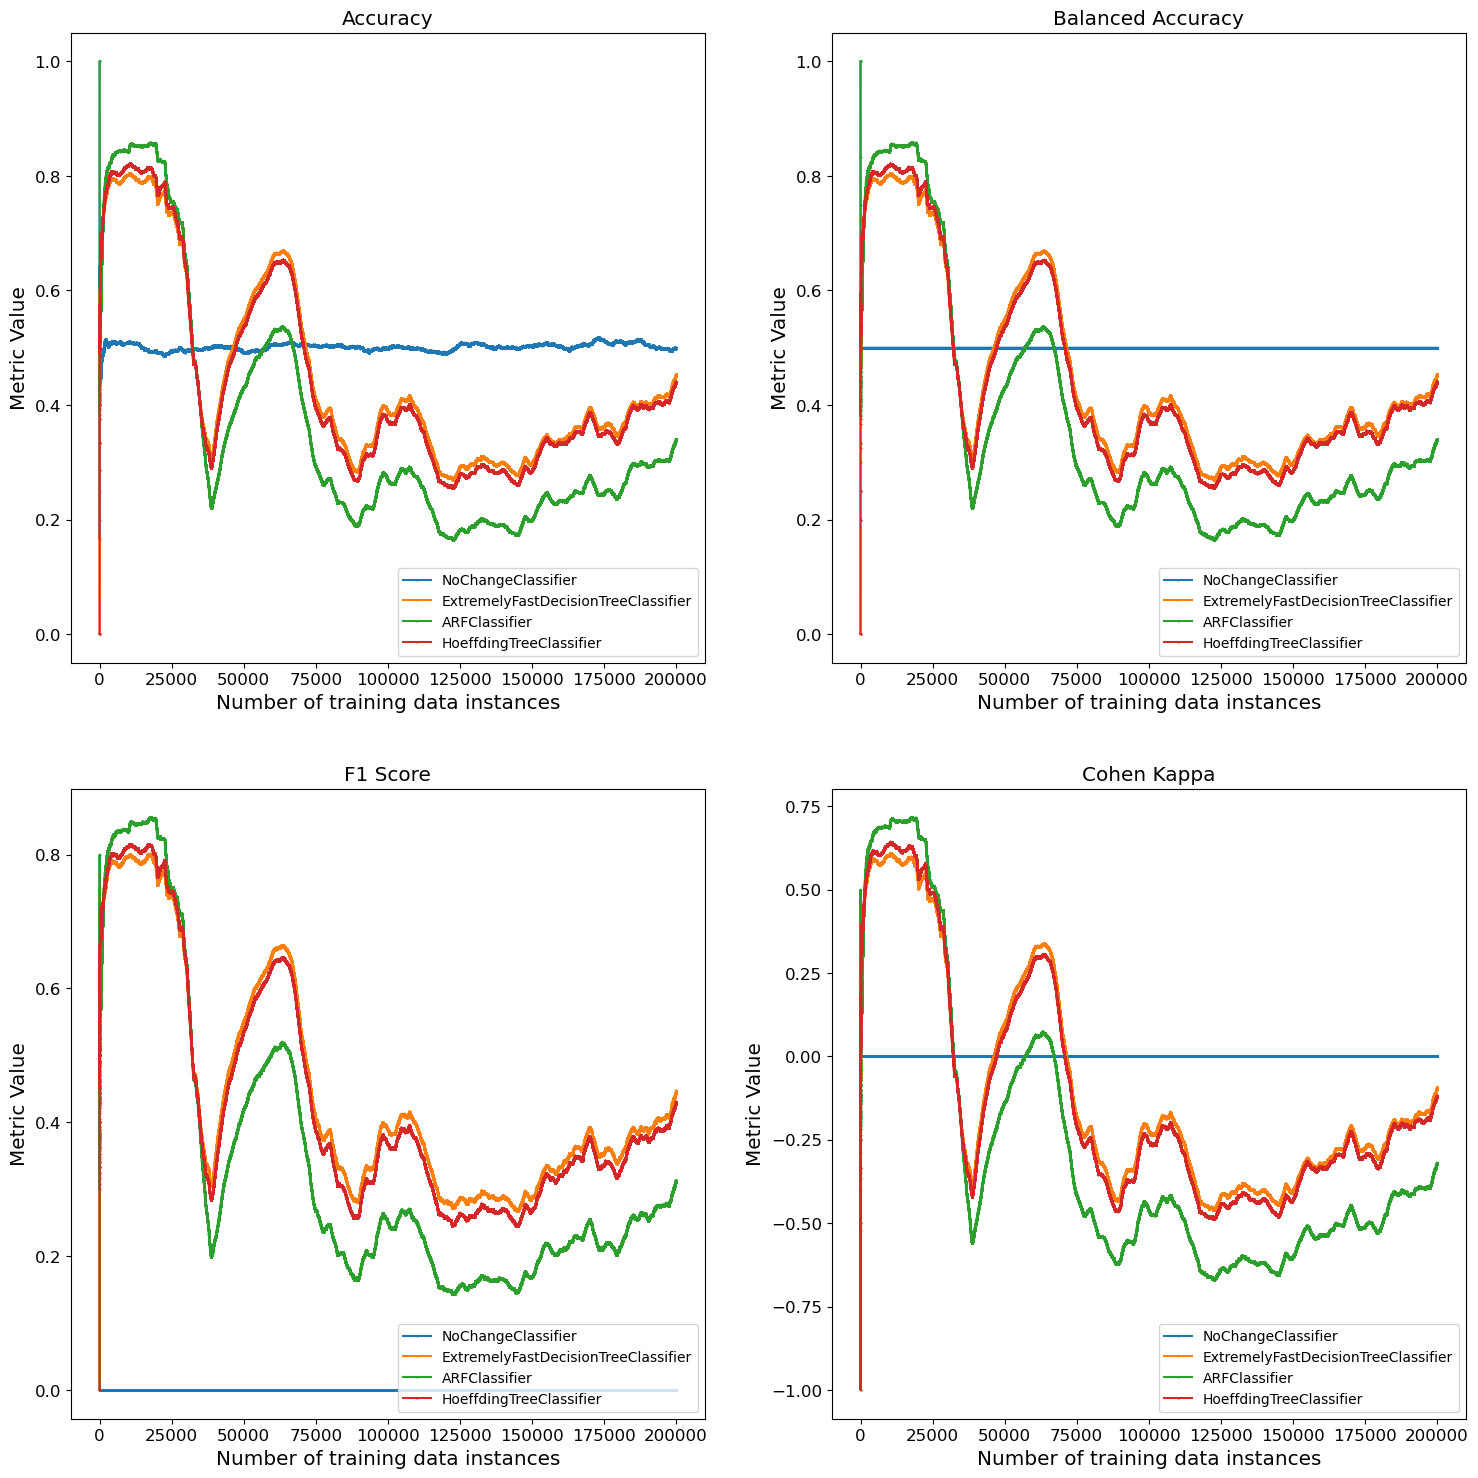

In [9]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 2 ---

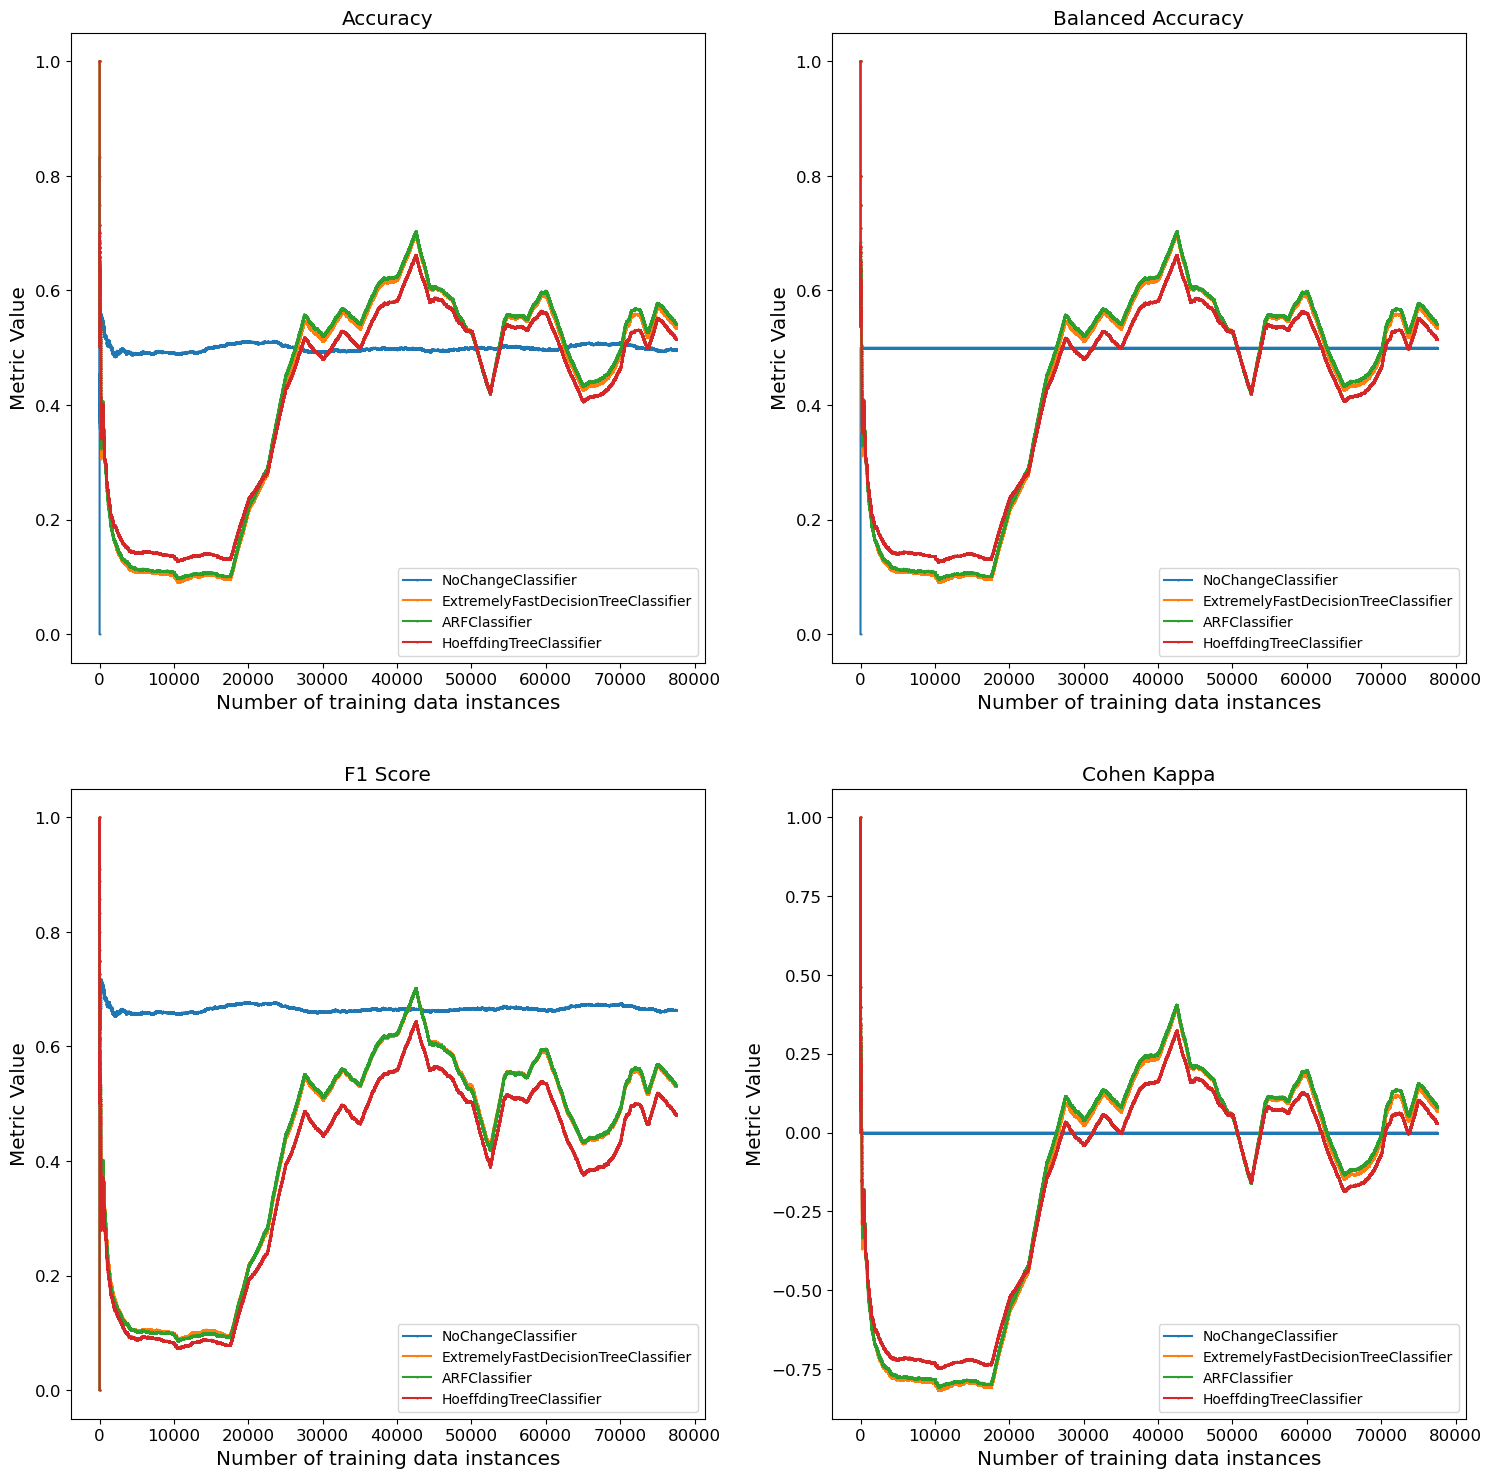

In [8]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 3 (seed = 55)

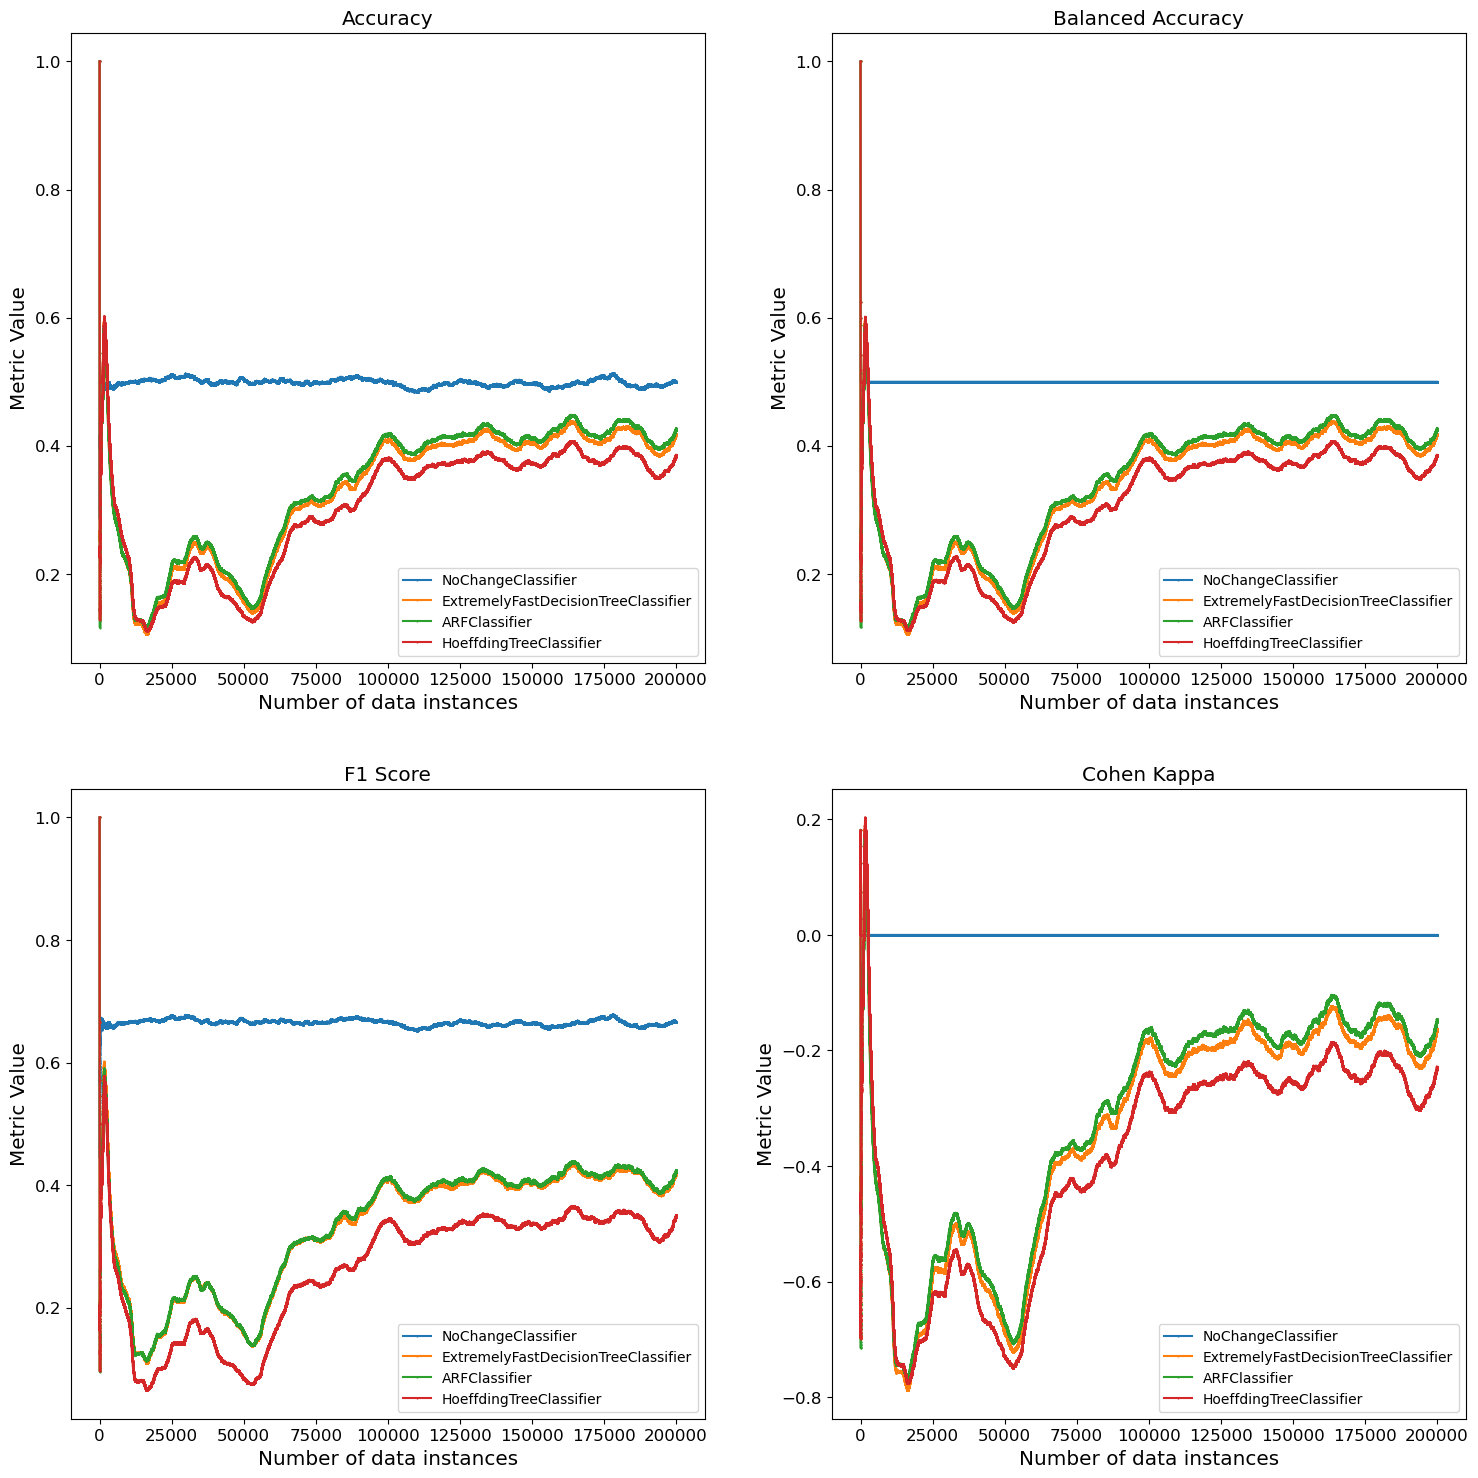

In [16]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 4 ( the same as training seed = 44)

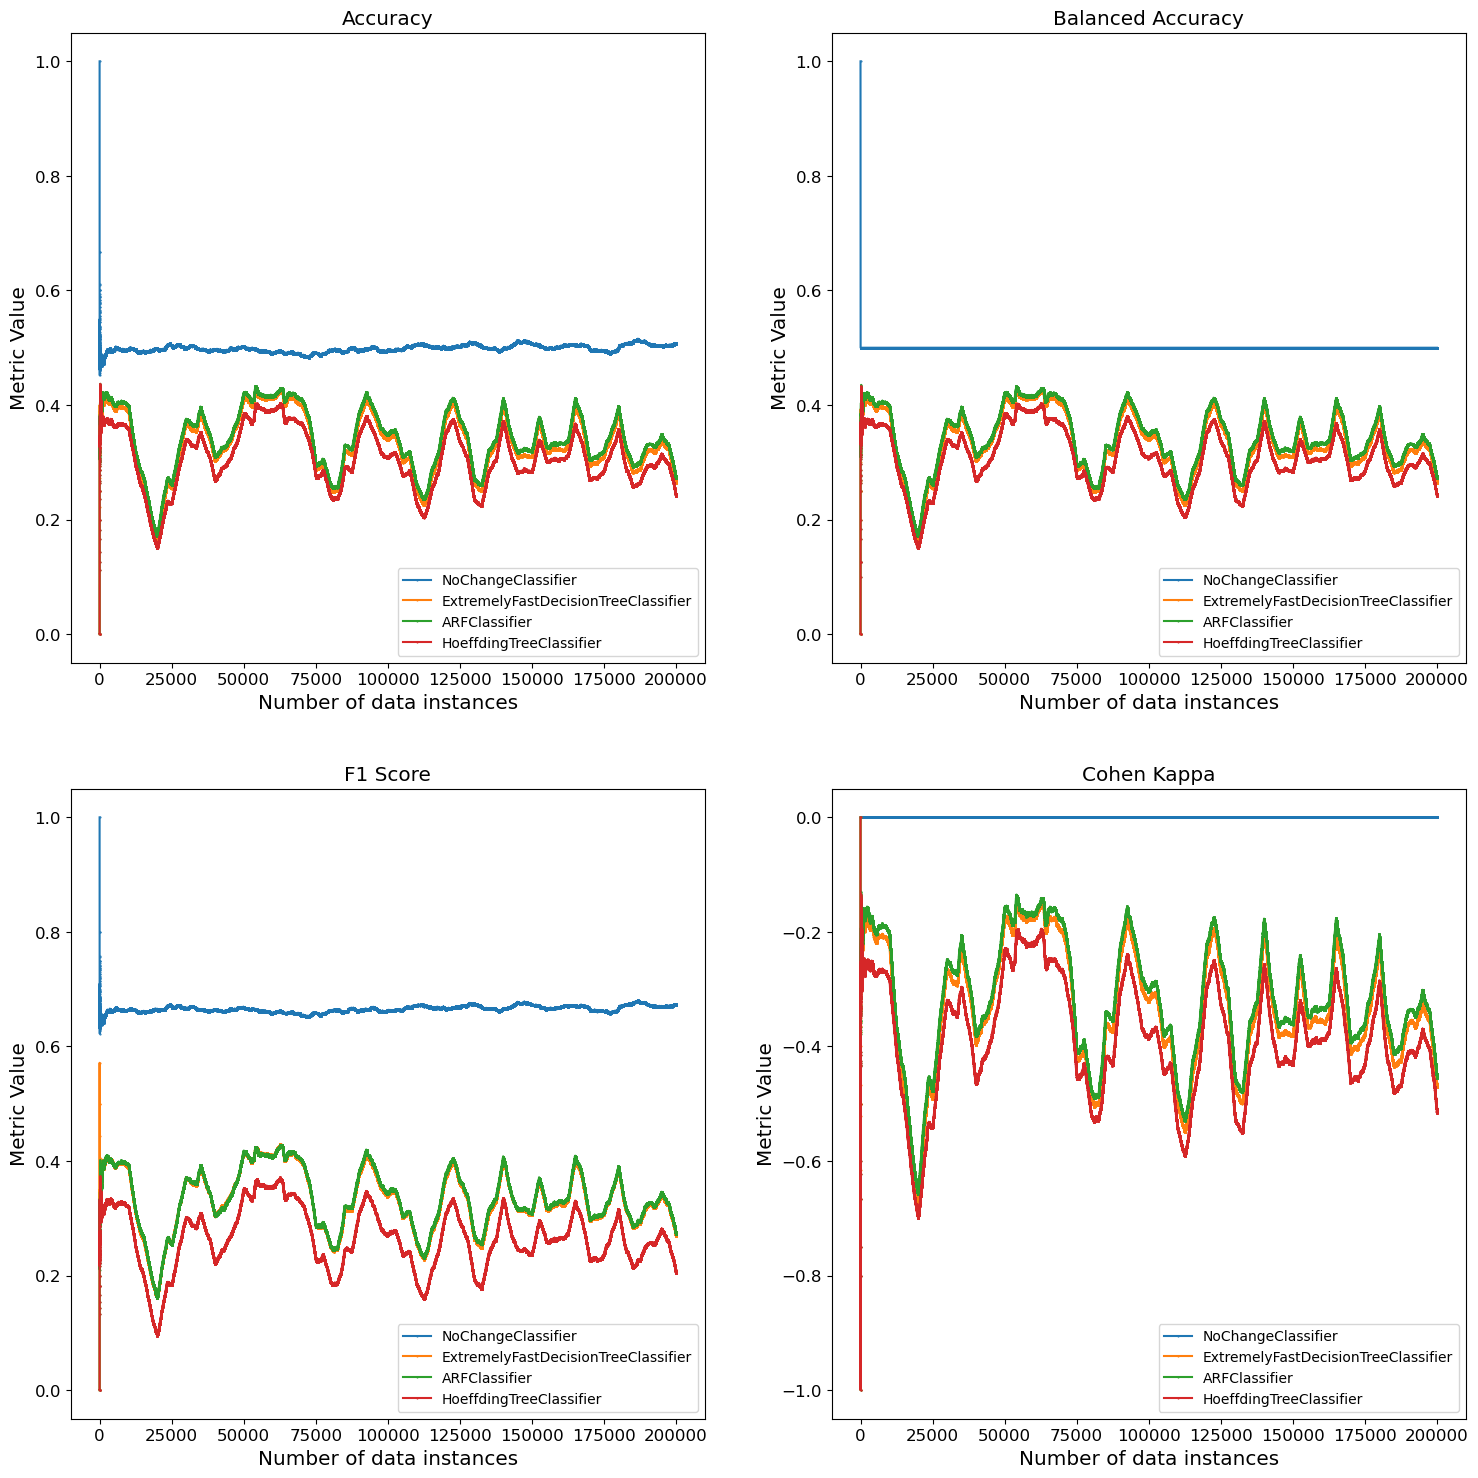

In [26]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
#...

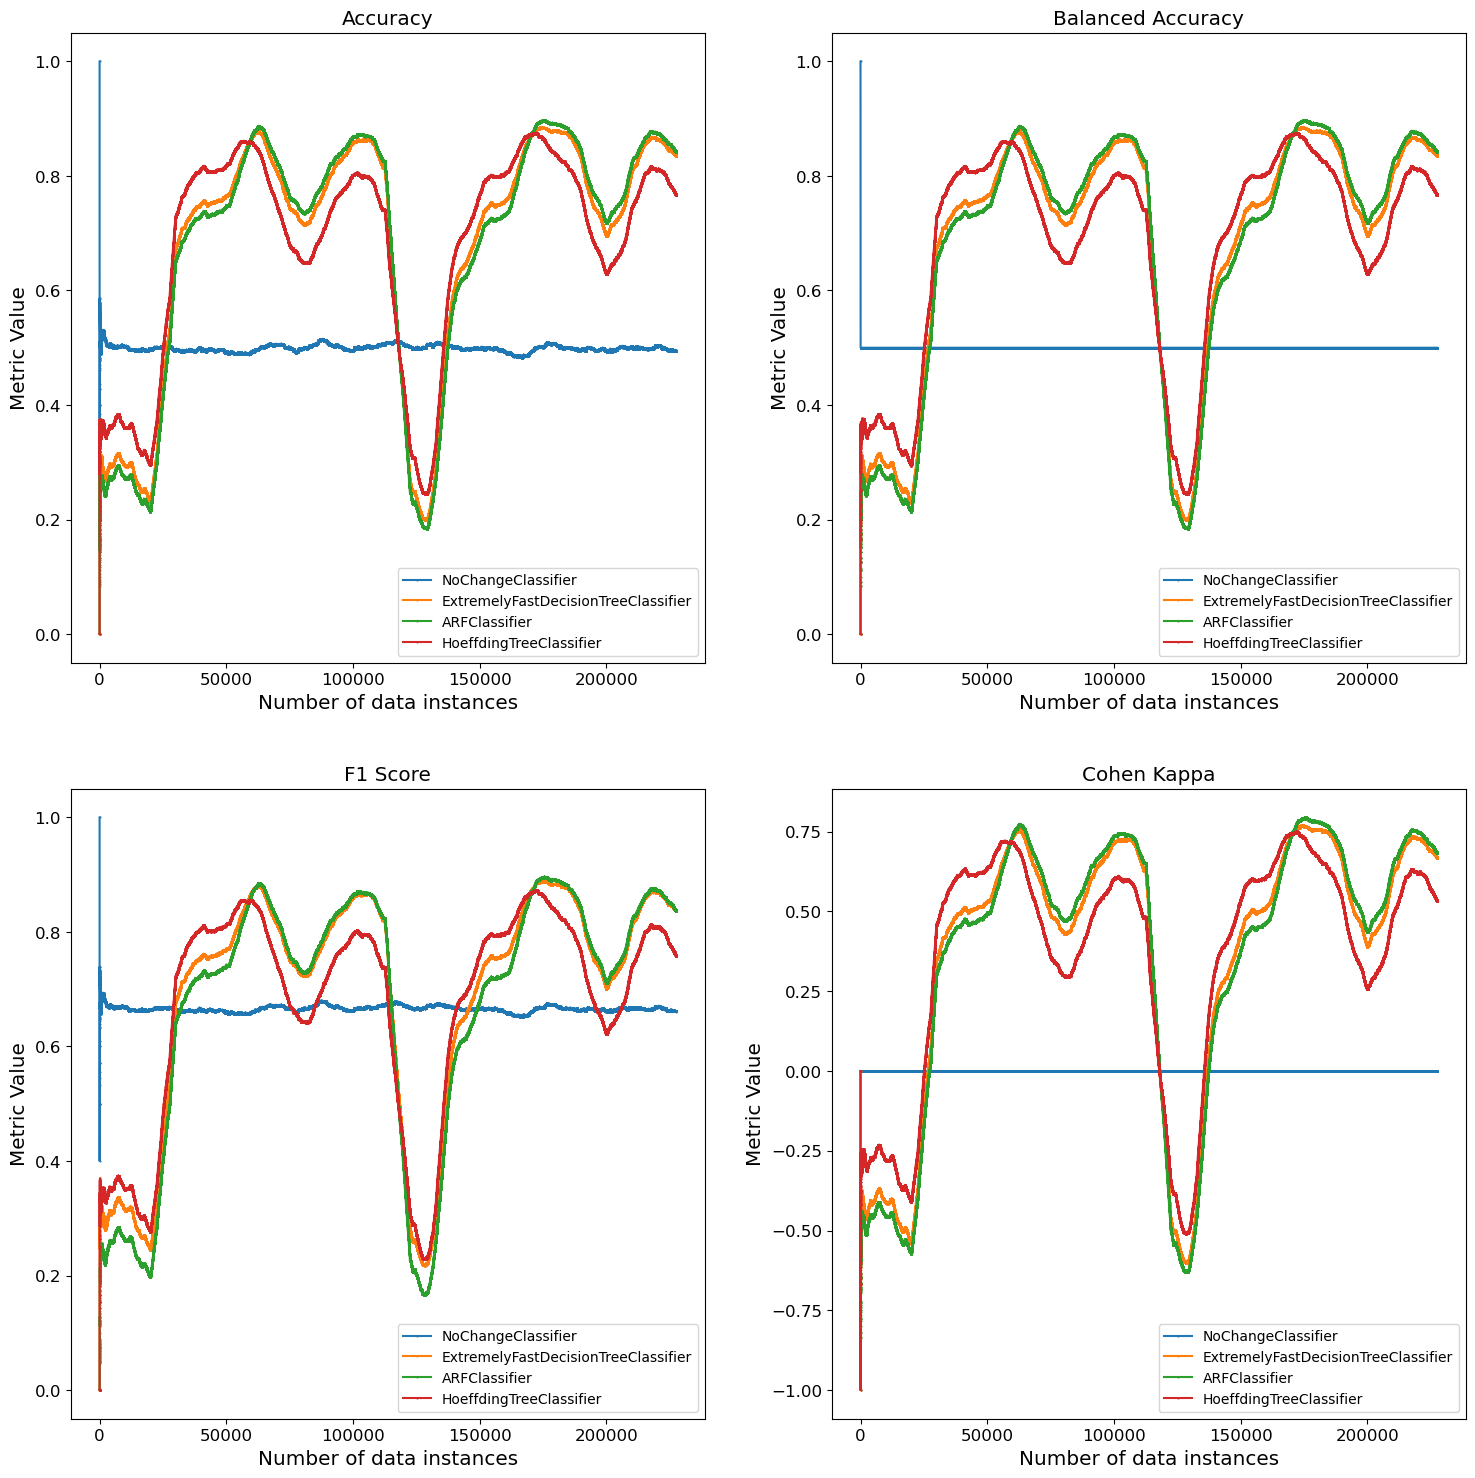

In [12]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

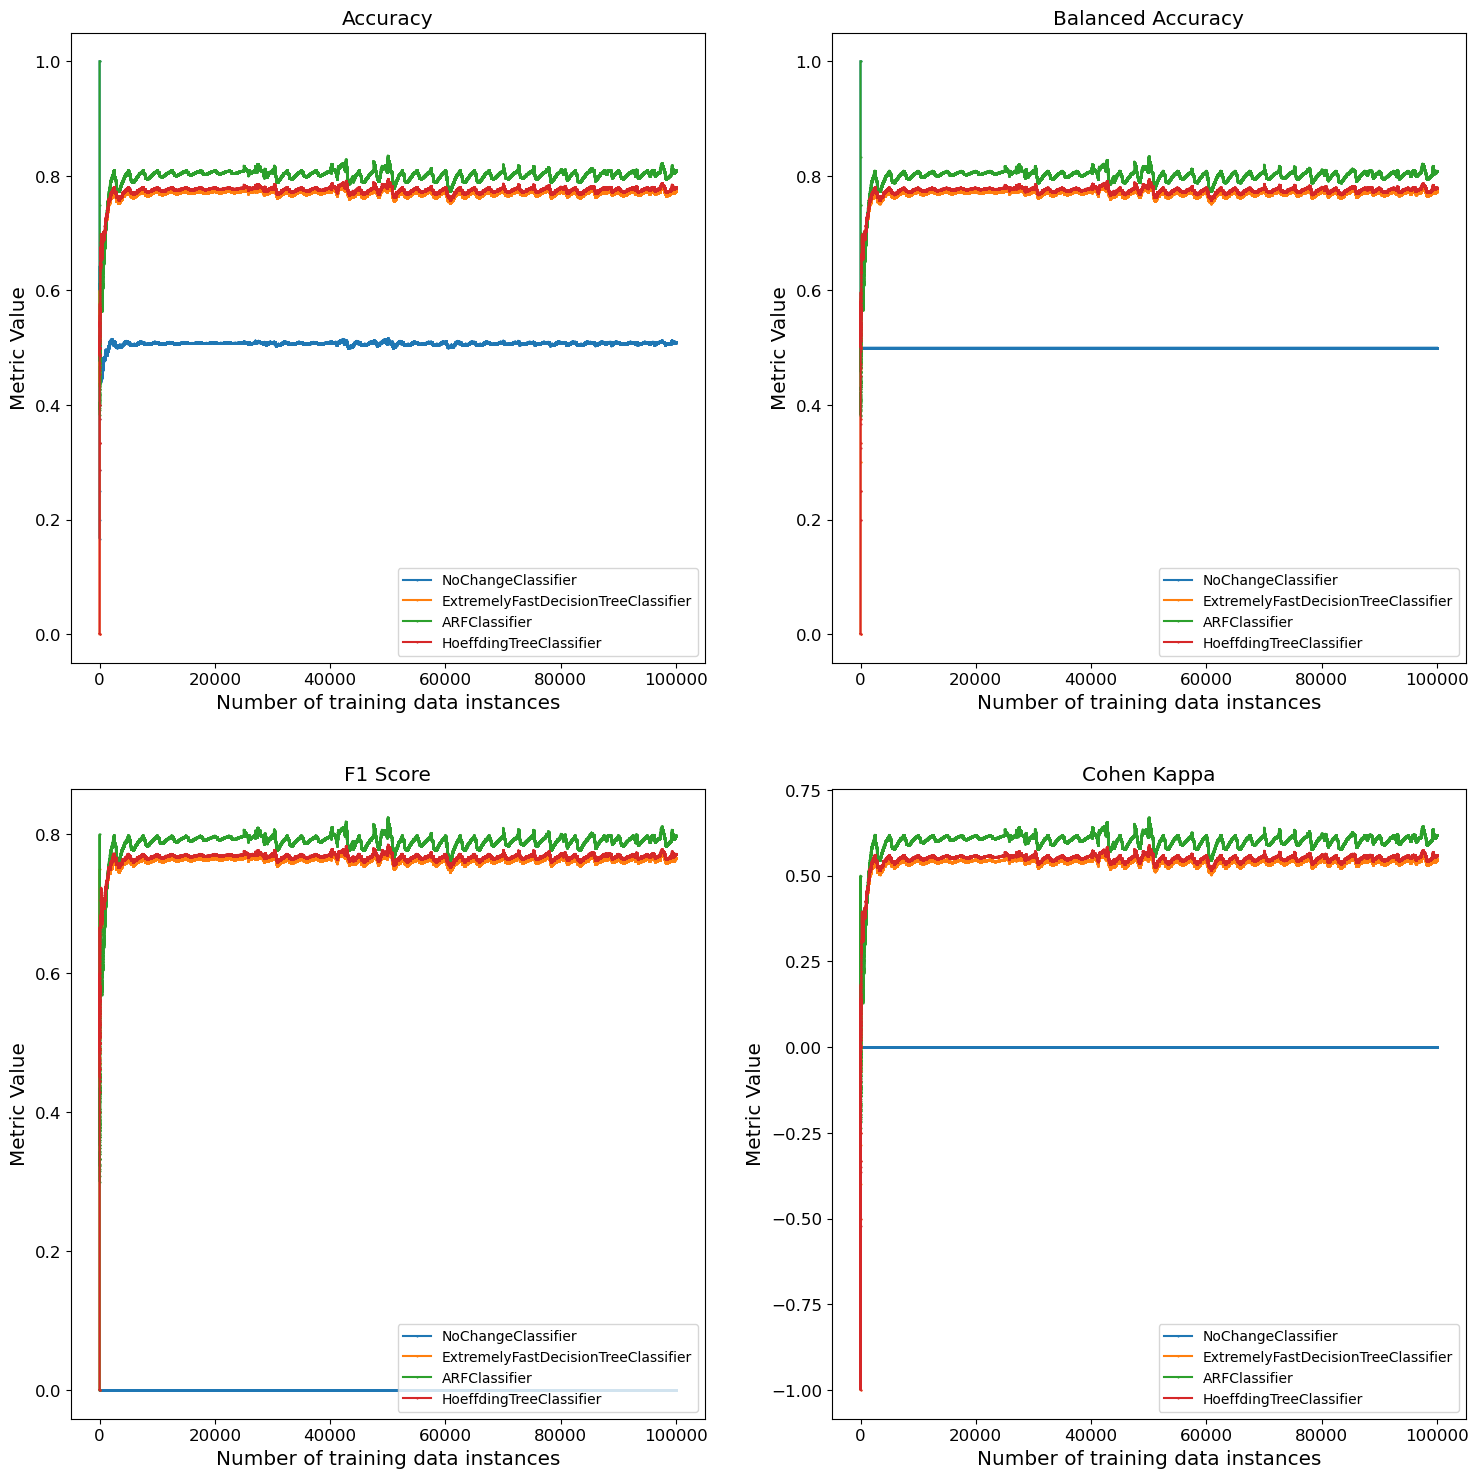

In [14]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [14]:
res = pdf.iloc[pdf.shape[0] - 1, :]
res

training_time                                    916.424744
n                                                    227500
hostname                                   cluster-9e14-w-0
hash                                       fkkyimyieglwnhxj
model_name                               NoChangeClassifier
prediction                                              1.0
R_Accuracy                                           0.4943
R_BalancedAccuracy                                      0.5
R_F1                                               0.661581
R_CohenKappa                                            0.0
Accuracy                                           0.499301
BalancedAccuracy                                        0.5
F1                                                 0.666045
CohenKappa                                              0.0
model_name_2            ExtremelyFastDecisionTreeClassifier
prediction_2                                            0.0
R_Accuracy_2                            

In [19]:
print("@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@")
#seed 55
print("-----NoChange classifier:")
print("Accuracy: " + str(res["Accuracy"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy"]))
print("F1 Score: " + str(res["F1"]))
print("Cohen Kappa: " + str(res["CohenKappa"]))

print("-----ExtremelyFast DT classifier:")
print("Accuracy: " + str(res["Accuracy_2"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_2"]))
print("F1 Score: " + str(res["F1_2"]))
print("Cohen Kappa: " + str(res["CohenKappa_2"]))

print("-----ARF classifier:")
print("Accuracy: " + str(res["Accuracy_3"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_3"]))
print("F1 Score: " + str(res["F1_3"]))
print("Cohen Kappa: " + str(res["CohenKappa_3"]))

print("-----Hoeffding Tree classifier:")
print("Accuracy: " + str(res["Accuracy_4"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_4"]))
print("F1 Score: " + str(res["F1_4"]))
print("Cohen Kappa: " + str(res["CohenKappa_4"]))

@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@
-----NoChange classifier:
Accuracy: 0.499265
Balanced Accuracy: 0.5
F1 Score: 0.666013
Cohen Kappa: 0.0
-----ExtremelyFast DT classifier:
Accuracy: 0.33203
Balanced Accuracy: 0.3320311
F1 Score: 0.3322103
Cohen Kappa: -0.33593604
-----ARF classifier:
Accuracy: 0.34124
Balanced Accuracy: 0.3412275
F1 Score: 0.33525062
Cohen Kappa: -0.31755206
-----Hoeffding Tree classifier:
Accuracy: 0.30631
Balanced Accuracy: 0.306228
F1 Score: 0.26498762
Cohen Kappa: -0.38760635


In [15]:
print("@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@")
#seed 44
print("-----NoChange classifier:")
print("Accuracy: " + str(res["Accuracy"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy"]))
print("F1 Score: " + str(res["F1"]))
print("Cohen Kappa: " + str(res["CohenKappa"]))

print("-----ExtremelyFast DT classifier:")
print("Accuracy: " + str(res["Accuracy_2"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_2"]))
print("F1 Score: " + str(res["F1_2"]))
print("Cohen Kappa: " + str(res["CohenKappa_2"]))

print("-----ARF classifier:")
print("Accuracy: " + str(res["Accuracy_3"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_3"]))
print("F1 Score: " + str(res["F1_3"]))
print("Cohen Kappa: " + str(res["CohenKappa_3"]))

print("-----Hoeffding Tree classifier:")
print("Accuracy: " + str(res["Accuracy_4"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_4"]))
print("F1 Score: " + str(res["F1_4"]))
print("Cohen Kappa: " + str(res["CohenKappa_4"]))

@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@
-----NoChange classifier:
Accuracy: 0.4993011
Balanced Accuracy: 0.5
F1 Score: 0.6660451
Cohen Kappa: 0.0
-----ExtremelyFast DT classifier:
Accuracy: 0.6967121
Balanced Accuracy: 0.6967461
F1 Score: 0.7036347
Cohen Kappa: 0.39346498
-----ARF classifier:
Accuracy: 0.6953319
Balanced Accuracy: 0.695305
F1 Score: 0.68905556
Cohen Kappa: 0.39063054
-----Hoeffding Tree classifier:
Accuracy: 0.69083077
Balanced Accuracy: 0.6908012
F1 Score: 0.683832
Cohen Kappa: 0.3816245


# Evaluator - Case 3

In [2]:
init = InitializeA()
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf
# spark.stop()

23/06/22 20:55:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-1_177460.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_177460.pkl',
                                       'ARFClassifier_cluster-9e14-w-1_177460.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-1_177460.pkl']}, 
        "cluster-9e14-w-1" : {"pretrained_models": ['NoChangeClassifier_cluster-9e14-w-1_177460.pkl', 
                                        'ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_177460.pkl',
                                       'ARFClassifier_cluster-9e14-w-1_177460.pkl',
                                       'HoeffdingTreeClassifier_cluster-9e14-w-1_177460.pkl']}, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000), 
                        metrics.Accuracy(), 
                        metrics.BalancedAccuracy(), 
                        metrics.F1(), 
                        metrics.CohenKappa()]}

In [4]:
data_cols = [field.name for field in input_schema.fields][:-1]

# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = evaluator_master.EvaluatorMaster(data_cols, task)

In [5]:
data_cols

['s', 'c', 'age', 'e', 'car', 'z', 'hv', 'hy', 'l']

In [5]:
output_schema = sm.output_schema
output_schema

StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('Accuracy', FloatType(), False), StructField('BalancedAccuracy', FloatType(), False), StructField('F1', FloatType(), False), StructField('CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('Accuracy_2', FloatType(),

In [37]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/em/case3", "/user/hdfs/evaluation/em/case3/chk")

23/06/22 19:42:41 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/06/22 19:42:41 WARN StreamingQueryManager: Stopping existing streaming query [id=b3cc680e-2e1b-47b7-b35e-64e11fcf6599, runId=6668add6-18f3-436e-96ae-dd37b9c01051], as a new run is being started.
23/06/22 19:42:41 WARN HadoopFSUtils: The directory hdfs://cluster-9e14-m/user/hdfs/stream/agrawal/8u4gvp17erxj0z44.csv was not found. Was it deleted very recently?
23/06/22 19:43:20 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 30316 milliseconds
23/06/22 19:43:31 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 11007 milliseconds
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway

KeyboardInterrupt: 

In [7]:
output_schema = sm.output_schema

df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/em/case3")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training
pdf = pdf[pdf["hostname"] == "cluster-9e14-w-0"]
print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["n"] <= 100000]

(200000, 44)
345.79425
(200000, 44)
345.79425


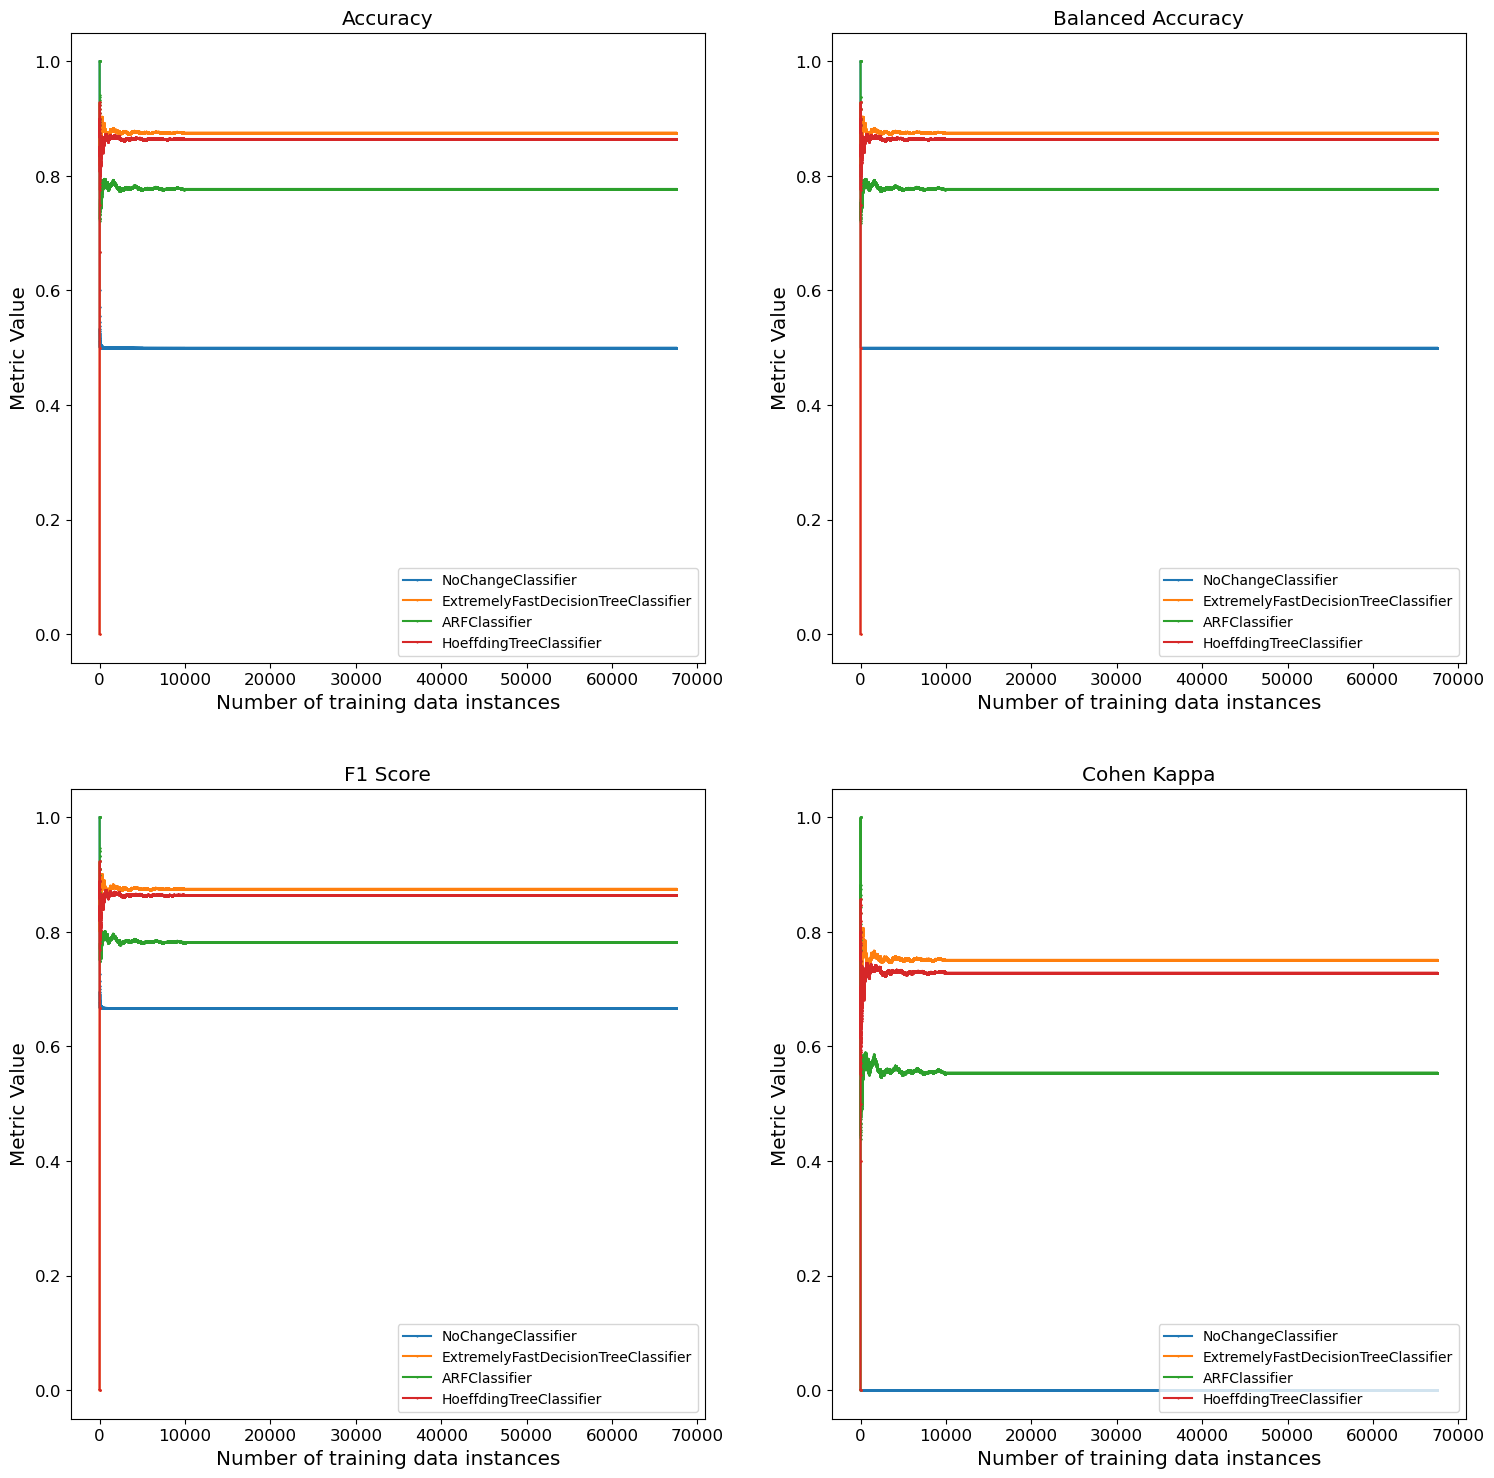

In [10]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Attempt 2 ---

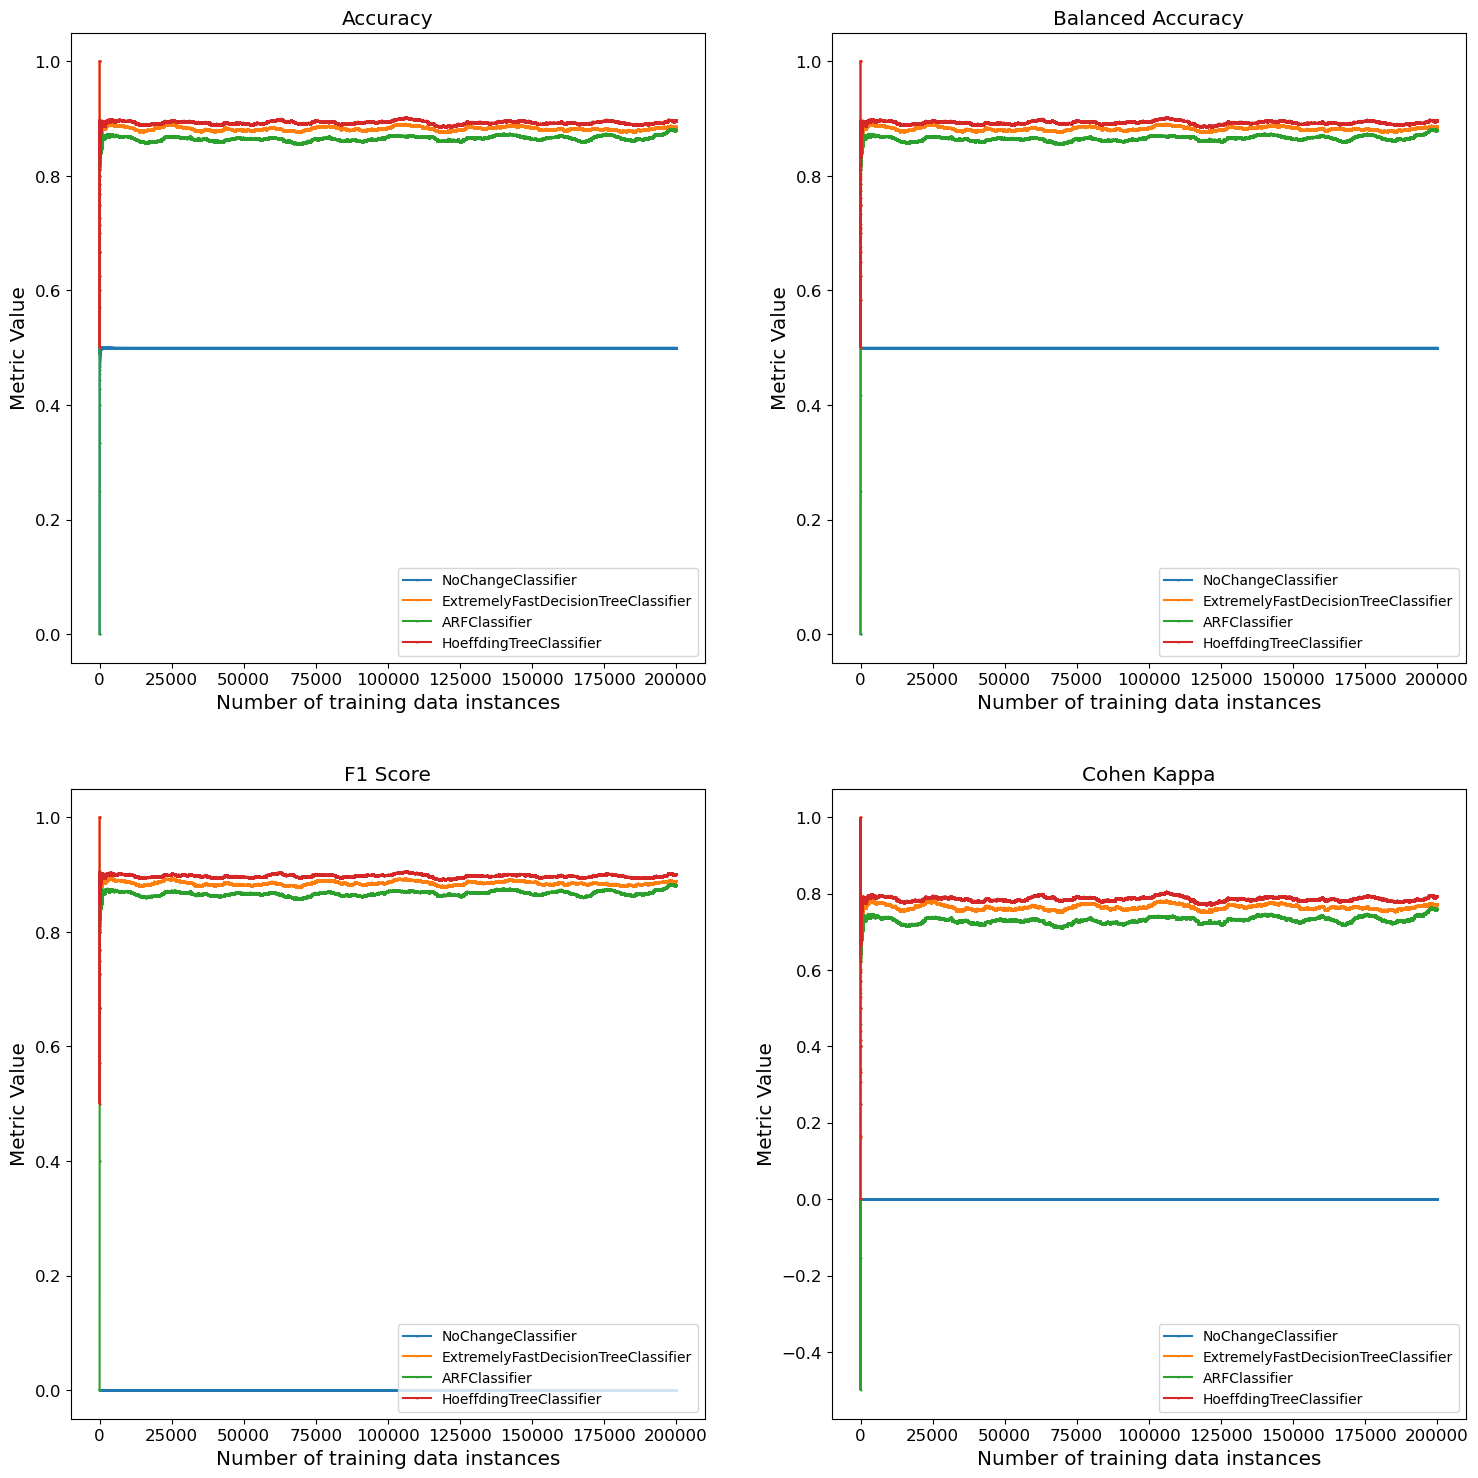

In [8]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

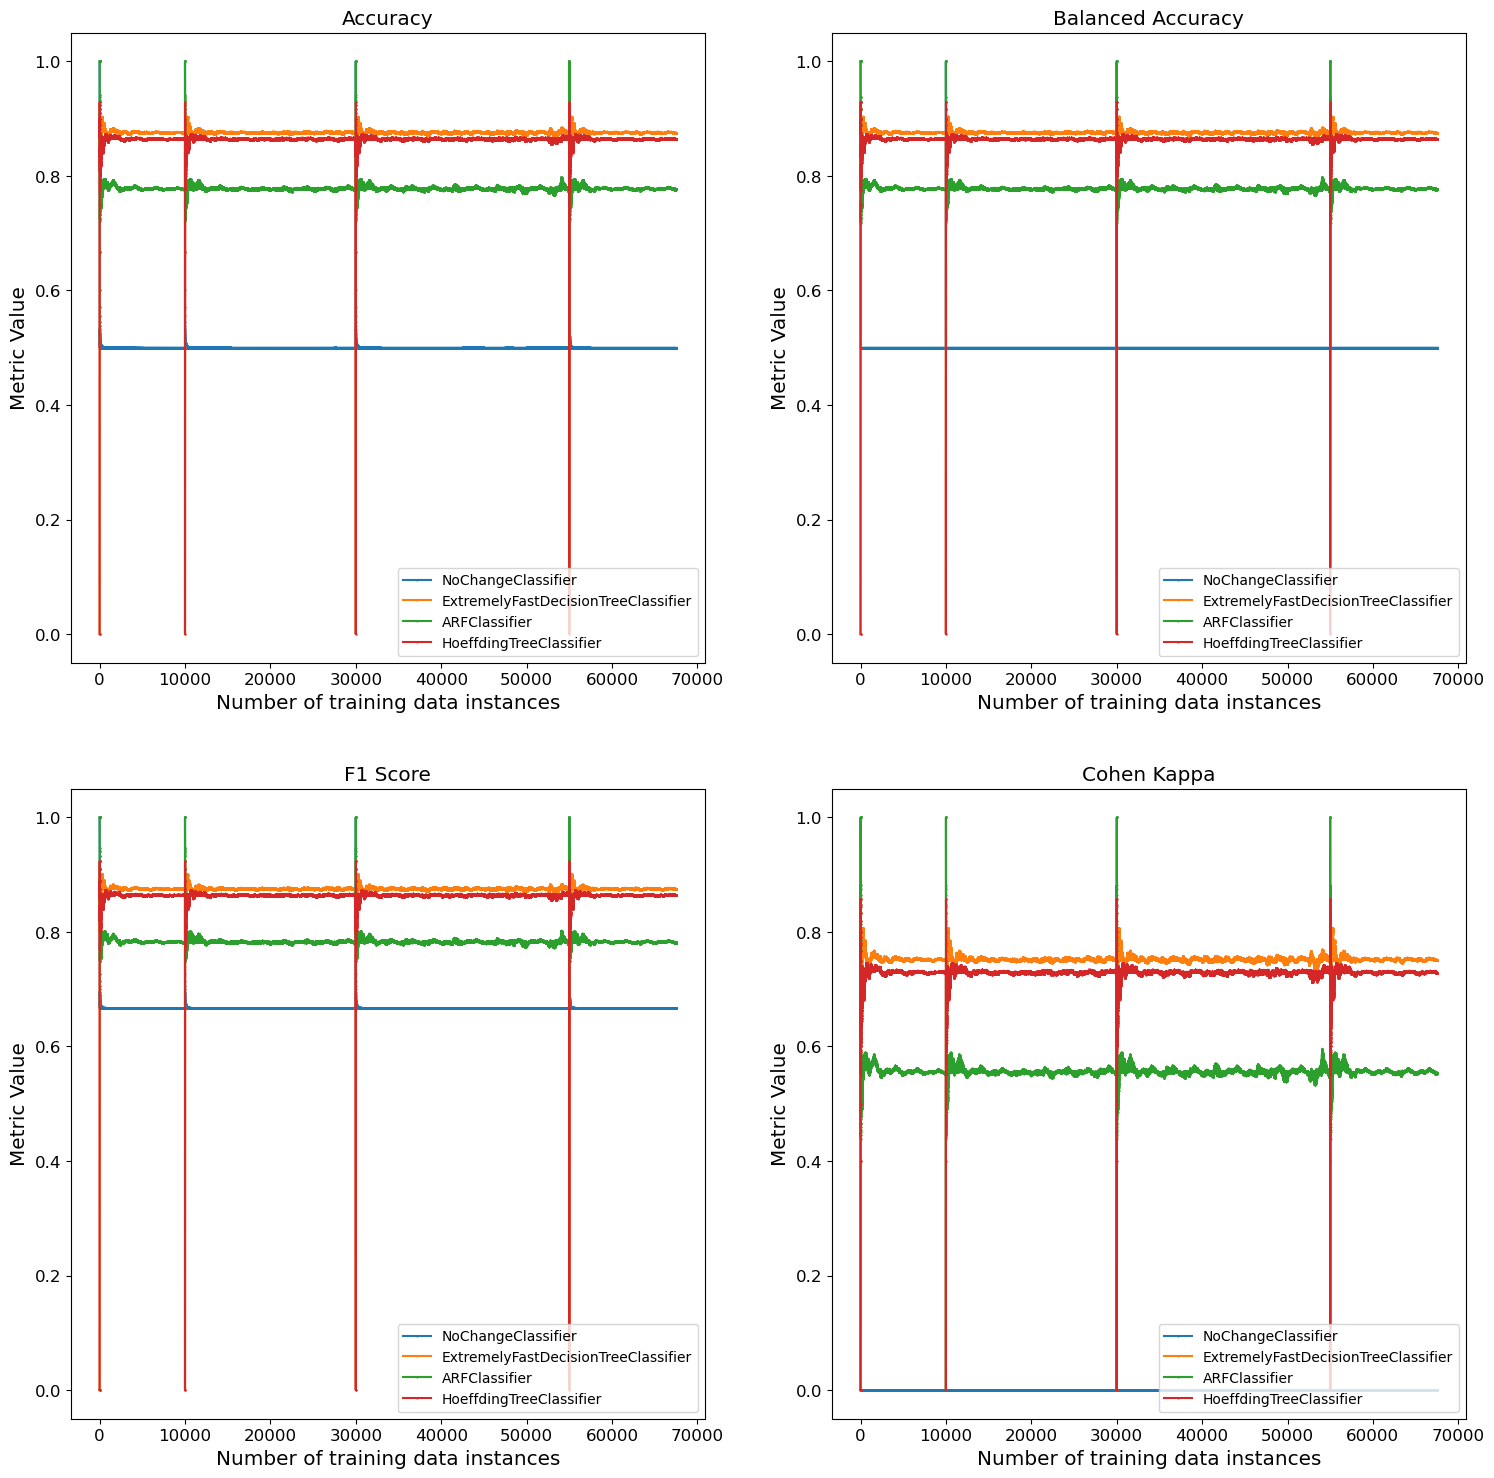

In [11]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf.n, pdf.TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [9]:
res = pdf.iloc[pdf.shape[0] - 1, :]
res

training_time                                     345.79425
n                                                    200000
hostname                                   cluster-9e14-w-0
hash                                       nxm23d11x0pf9fru
model_name                               NoChangeClassifier
prediction                                              0.0
R_Accuracy                                              0.5
R_BalancedAccuracy                                      0.5
R_F1                                                    0.0
R_CohenKappa                                            0.0
Accuracy                                                0.5
BalancedAccuracy                                        0.5
F1                                                      0.0
CohenKappa                                              0.0
model_name_2            ExtremelyFastDecisionTreeClassifier
prediction_2                                            0.0
R_Accuracy_2                            

In [10]:
print("@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@")
#seed 44
print("-----NoChange classifier:")
print("Accuracy: " + str(res["Accuracy"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy"]))
print("F1 Score: " + str(res["F1"]))
print("Cohen Kappa: " + str(res["CohenKappa"]))

print("-----ExtremelyFast DT classifier:")
print("Accuracy: " + str(res["Accuracy_2"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_2"]))
print("F1 Score: " + str(res["F1_2"]))
print("Cohen Kappa: " + str(res["CohenKappa_2"]))

print("-----ARF classifier:")
print("Accuracy: " + str(res["Accuracy_3"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_3"]))
print("F1 Score: " + str(res["F1_3"]))
print("Cohen Kappa: " + str(res["CohenKappa_3"]))

print("-----Hoeffding Tree classifier:")
print("Accuracy: " + str(res["Accuracy_4"]))
print("Balanced Accuracy: " + str(res["BalancedAccuracy_4"]))
print("F1 Score: " + str(res["F1_4"]))
print("Cohen Kappa: " + str(res["CohenKappa_4"]))

@@@@@@@@@@@@@@@@@@@HYPERPLANE PPRETRAINED MODELS EVALUATION@@@@@@@@@@@@@@@@@@@
-----NoChange classifier:
Accuracy: 0.5
Balanced Accuracy: 0.5
F1 Score: 0.0
Cohen Kappa: 0.0
-----ExtremelyFast DT classifier:
Accuracy: 0.882935
Balanced Accuracy: 0.882935
F1 Score: 0.8855362
Cohen Kappa: 0.76587
-----ARF classifier:
Accuracy: 0.866225
Balanced Accuracy: 0.866225
F1 Score: 0.86812335
Cohen Kappa: 0.73245
-----Hoeffding Tree classifier:
Accuracy: 0.89352
Balanced Accuracy: 0.89352
F1 Score: 0.8981267
Cohen Kappa: 0.78704
